# Stroke Predictor 

Anomaly Detection and Imbalanced Classification of patient clinical features to predict if they will have a stroke

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, average_precision_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
path = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(path)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

# EDA + Data Cleaning

In [3]:
df.shape

(5110, 12)

Let's check if the dateset is balanced 

In [4]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

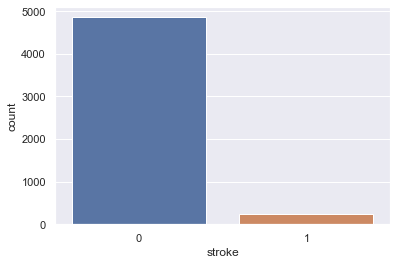

In [5]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="stroke", data=df)

Looks like dataset is highly imabalanced in favor of non-stroke patients (> 20:1). Hence, the dataset will need to be balanced before building the model.

Let's check if the gender split is balanced

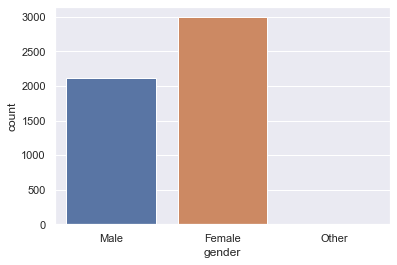

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="gender", data=df)

In [7]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

The male/female split is not too imbalanced but we should get rid of the 'Other' outlier.

In [8]:
df.drop(df[df.gender == "Other"].index, inplace = True)

In [9]:
df.gender.value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [10]:
df.shape

(5109, 12)

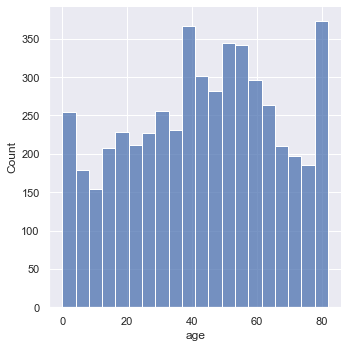

In [11]:
sns.set_theme(style="darkgrid")
sns.displot(df, x="age")

Patient age is distributed without any outliers.

In [12]:
df.age.describe()

count    5109.000000
mean       43.229986
std        22.613575
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

Let's explore the remaining clinical features of the patients.

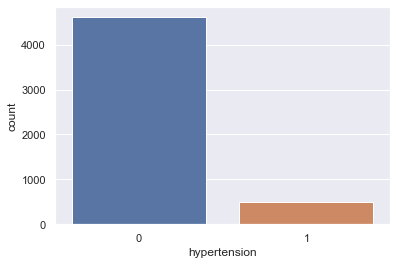

In [13]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="hypertension", data=df)

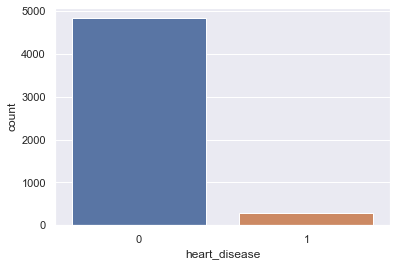

In [14]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="heart_disease", data=df)

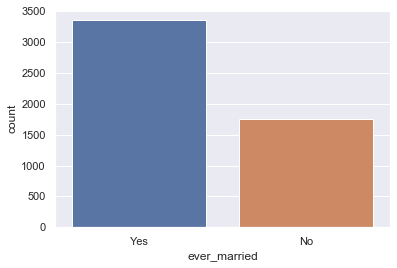

In [15]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="ever_married", data=df)

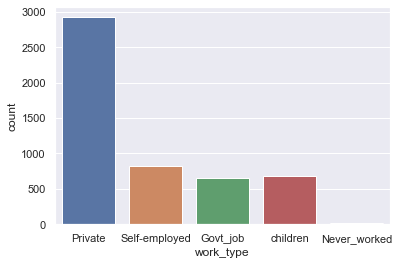

In [16]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="work_type", data=df)

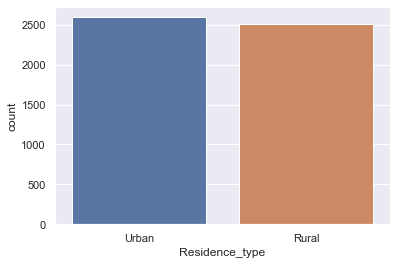

In [17]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Residence_type", data=df)

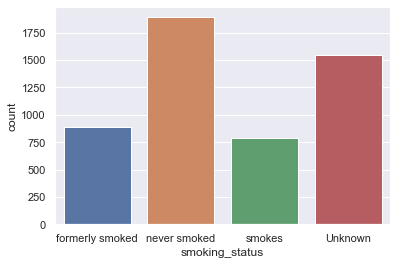

In [18]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="smoking_status", data=df)

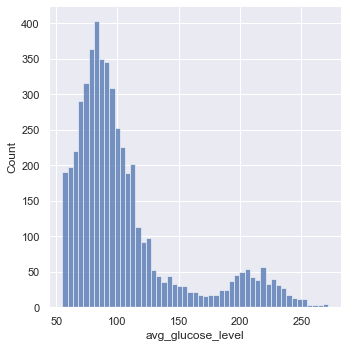

In [19]:
sns.set_theme(style="darkgrid")
sns.displot(df, x="avg_glucose_level")

In [20]:
df.avg_glucose_level.describe()

count    5109.000000
mean      106.140399
std        45.285004
min        55.120000
25%        77.240000
50%        91.880000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

Patient average glucose level is right skewed where the majority of patients have a glucose level on the lower end of the spectrum, hence majority of patients have a healthy glucose level. No visible outliers exist in this clinical feature

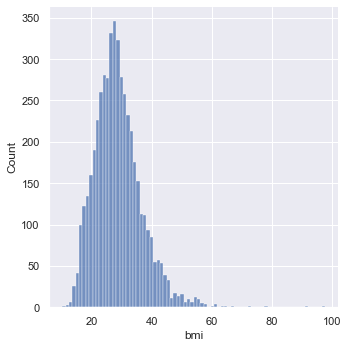

In [21]:
sns.set_theme(style="darkgrid")
sns.displot(df, x="bmi")

In [22]:
df.bmi.describe()

count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64

Patient BMI is normally distributed with some apparent outliers, which may or may not affect the model performance.

Let's check the stroke/no-stroke split once again before data cleaning

In [23]:
df.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

Let's clean the data by checking for missing values

In [24]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Drop missing values

In [25]:
df.dropna(inplace=True)

In [26]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

We dropped all missing values

In [27]:
df.shape

(4908, 12)

Let's check the stroke/no-stroke split after data cleaning

In [28]:
df.stroke.value_counts()

0    4699
1     209
Name: stroke, dtype: int64

# Feature Engineering

First step is to drop the id column since it doesn't add any information to the dataset.

In [29]:
df.drop('id', axis=1, inplace = True)

In [30]:
df.shape

(4908, 11)

Let's build a baseline model with minimal feature engineering.

In [31]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

Let's encode the categorical variables

In [32]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Need to encode the object data types only.

In [33]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [0,4,5,6,9])], remainder = 'passthrough')
X = np.array(ct.fit_transform(X))

In [34]:
print(X)

[[0.0 1.0 0.0 ... 1 228.69 36.6]
 [0.0 1.0 0.0 ... 1 105.92 32.5]
 [1.0 0.0 0.0 ... 0 171.23 34.4]
 ...
 [1.0 0.0 0.0 ... 0 82.99 30.6]
 [0.0 1.0 0.0 ... 0 166.29 25.6]
 [1.0 0.0 0.0 ... 0 85.28 26.2]]


In [35]:
X.shape

(4908, 20)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
X_train.shape

(3435, 20)

In [38]:
X_test.shape

(1473, 20)

Let's perform feature scaling

In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
X_train

array([[ 0.82494144, -0.82494144, -0.71732159, ..., -0.22888798,
        -1.01359259, -0.42636541],
       [ 0.82494144, -0.82494144,  1.39407487, ..., -0.22888798,
        -0.67440535, -0.68312199],
       [ 0.82494144, -0.82494144,  1.39407487, ..., -0.22888798,
        -0.46184801, -0.05406838],
       ...,
       [ 0.82494144, -0.82494144, -0.71732159, ..., -0.22888798,
        -0.24160243,  0.71620135],
       [-1.21220726,  1.21220726, -0.71732159, ..., -0.22888798,
         0.26898743,  1.40944411],
       [-1.21220726,  1.21220726, -0.71732159, ..., -0.22888798,
        -1.06424456, -0.00271706]])

In [41]:
X_test

array([[-1.21220726,  1.21220726, -0.71732159, ..., -0.22888798,
        -0.06228544,  0.44660695],
       [ 0.82494144, -0.82494144,  1.39407487, ..., -0.22888798,
        -0.47157138,  0.33106649],
       [-1.21220726,  1.21220726, -0.71732159, ..., -0.22888798,
        -0.67802335,  0.42093129],
       ...,
       [ 0.82494144, -0.82494144, -0.71732159, ..., -0.22888798,
         0.1084388 ,  1.66620068],
       [-1.21220726,  1.21220726, -0.71732159, ..., -0.22888798,
        -1.05452119, -0.61893284],
       [ 0.82494144, -0.82494144,  1.39407487, ..., -0.22888798,
        -0.73545906, -1.06825685]])

# Model Building

Let's build a pipeline of baseline classifiers with default parameters

In [42]:
def model_pipeline(X_tr, X_ts, y_tr, y_ts):
    
    classifiers = [
        {
            'label': 'SVM',
            'model': SVC(), 
        },
        {
            'label': 'KNN',
            'model': KNeighborsClassifier(), 
        },
               {
            'label': 'DT',
            'model': DecisionTreeClassifier(), 
        },
               {
            'label': 'RF',
            'model': RandomForestClassifier(), 
        },
               {
            'label': 'Logistic Regression',
            'model': LogisticRegression(), 
        },
               {
            'label': 'GNB',
            'model': GaussianNB(), 
        },
               {
            'label': 'MLP',
            'model': MLPClassifier(), 
        }
    ]
        
    
    for clf in classifiers:
        model = clf['model']
        model.fit(X_tr, y_tr)
        preds = model.predict(X_ts)
        
        print(clf['label'] + ' Classification Report')
        print(classification_report(y_ts,preds))
        plot_confusion_matrix(model, X_ts, y_ts, display_labels=['Non-Stroke','Stroke'])
        plt.grid(False)
        plt.title('Confusion Matrix', fontweight='bold', fontsize=15)
        plt.show()
        plot_roc_curve(model, X_ts, y_ts)
        plt.title('ROC Curve', fontweight='bold', fontsize=15)
        plt.show()
        plot_precision_recall_curve(model, X_ts, y_ts)
        plt.title('Precision-Recall Curve', fontweight='bold', fontsize=15)
        plt.show()

SVM Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.00      0.00      0.00        72

    accuracy                           0.95      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.90      0.95      0.93      1473



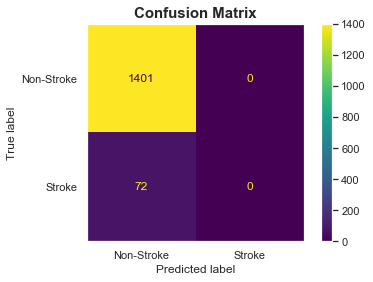

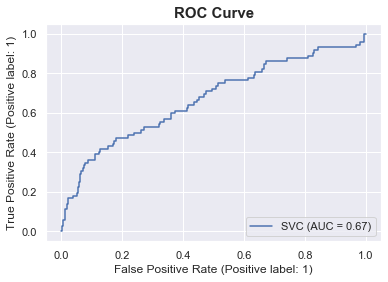

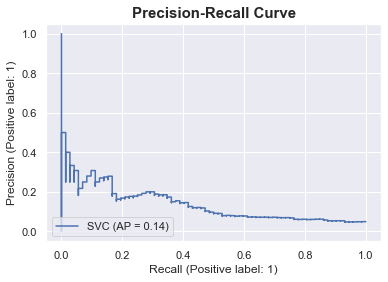

KNN Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1401
           1       0.67      0.03      0.05        72

    accuracy                           0.95      1473
   macro avg       0.81      0.51      0.51      1473
weighted avg       0.94      0.95      0.93      1473



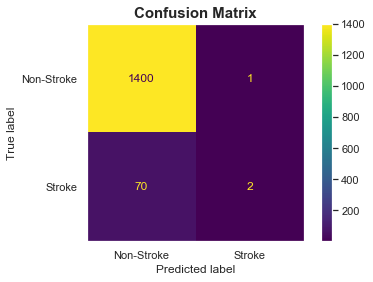

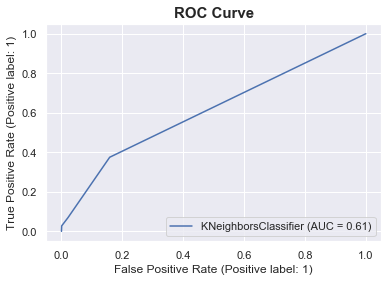

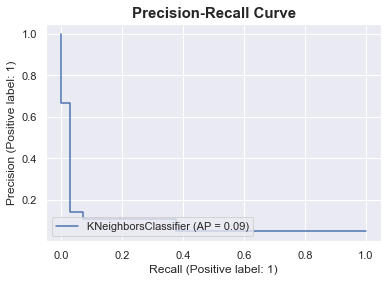

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1401
           1       0.14      0.15      0.15        72

    accuracy                           0.91      1473
   macro avg       0.55      0.55      0.55      1473
weighted avg       0.92      0.91      0.91      1473



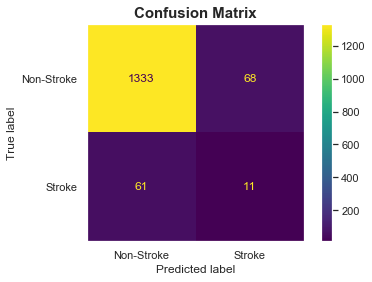

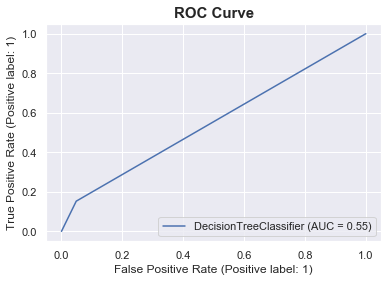

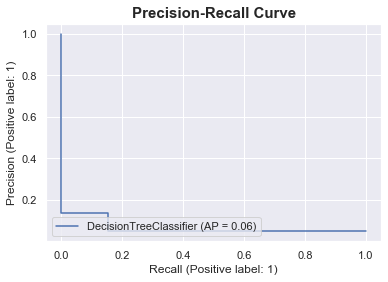

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.33      0.01      0.03        72

    accuracy                           0.95      1473
   macro avg       0.64      0.51      0.50      1473
weighted avg       0.92      0.95      0.93      1473



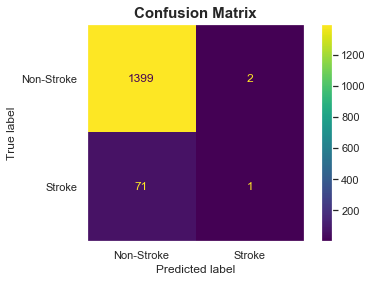

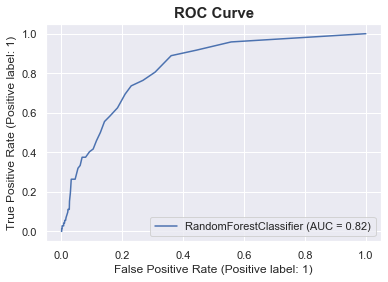

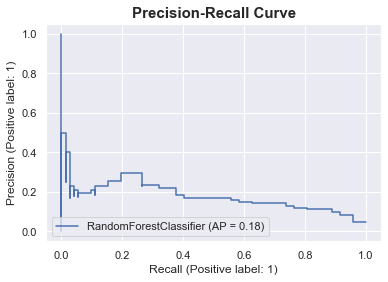

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.00      0.00      0.00        72

    accuracy                           0.95      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.90      0.95      0.93      1473



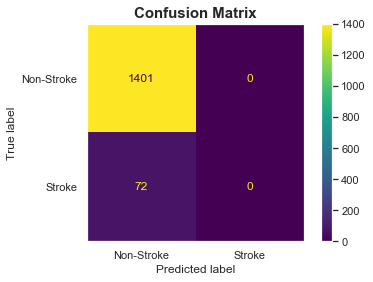

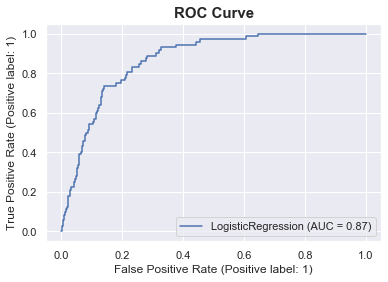

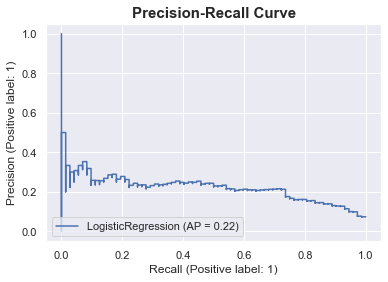

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.34      0.51      1401
           1       0.07      0.96      0.13        72

    accuracy                           0.37      1473
   macro avg       0.53      0.65      0.32      1473
weighted avg       0.95      0.37      0.49      1473



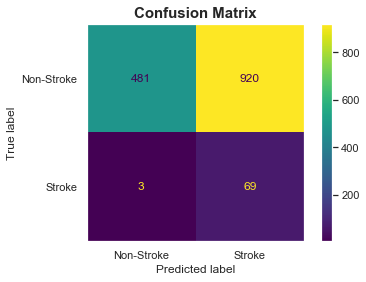

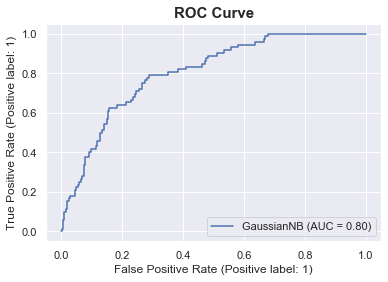

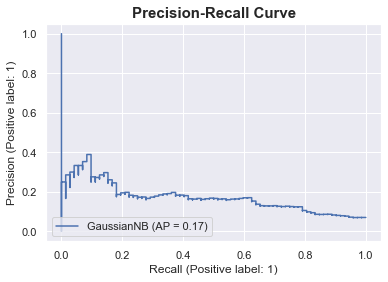

MLP Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.33      0.03      0.05        72

    accuracy                           0.95      1473
   macro avg       0.64      0.51      0.51      1473
weighted avg       0.92      0.95      0.93      1473



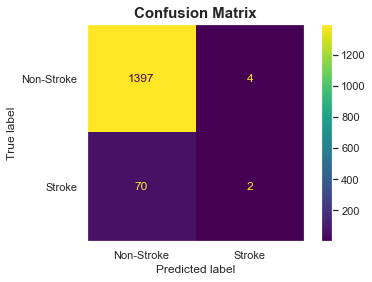

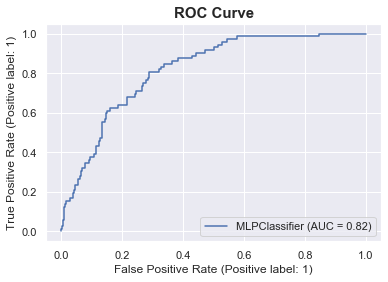

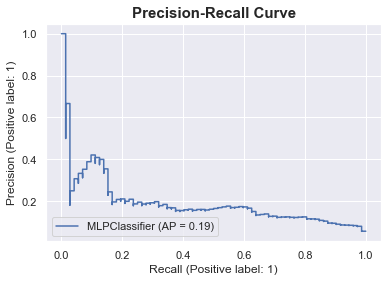

In [43]:
model_pipeline(X_train, X_test, y_train, y_test)

In [44]:
from collections import Counter
counter = Counter(y_test)
print(counter)

Counter({0: 1401, 1: 72})


Since the dataset is imbalanced, accuracy is not a useful metric. Instead we will look look at precision and recall to evalute our classifier. For this particular application, the most important metric is recall since it is essential to correctly predict the patients who will get a stroke so that they can be put on medication in advance and avoid getting the stroke (preventive step). Precision is of lesser importance, but still significant, as it will prevent doctors from wrongly prescribing stroke prevention medications to patients who are not likely to have a stroke. So, ideally we want to maximize recall while maintaining a reasonable precision.    

Only GNB gave a good recall score (96%) but with a low precision (7%). This is a very good recall score but we would like to significantly increase the precision.

# Oversampling/Undersampling

Let's do some more feature engineering to improve precision without compromising recall.

Let's start with balancing the dataset as it is highly imbalanced. We will use SMOTE for this.

In [45]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [46]:
counter1 = Counter(y_train)
counter2 = Counter(y_resampled)
print(counter1)
print(counter2)

Counter({0: 3298, 1: 137})
Counter({0: 3298, 1: 3298})


In [47]:
X_resampled.shape

(6596, 20)

In [48]:
y_resampled.shape

(6596,)

In [49]:
X_test.shape

(1473, 20)

In [50]:
y_test.shape

(1473,)

We have upsampled the minority class in the training set by generating synthetic samples. Let's run the classifiers again on the new training data.

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1401
           1       0.15      0.43      0.22        72

    accuracy                           0.85      1473
   macro avg       0.56      0.65      0.57      1473
weighted avg       0.93      0.85      0.88      1473



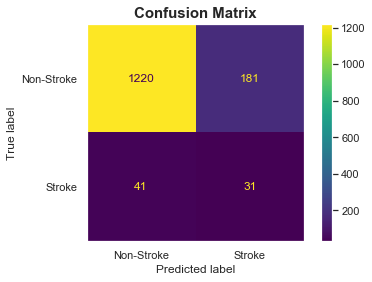

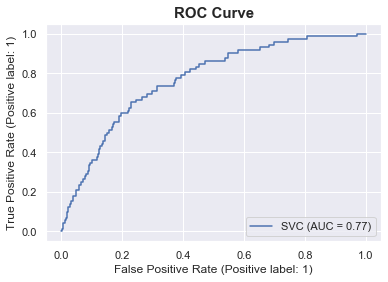

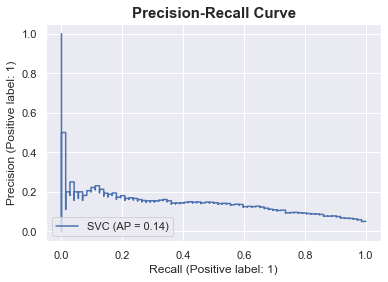

KNN Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1401
           1       0.10      0.28      0.15        72

    accuracy                           0.84      1473
   macro avg       0.53      0.57      0.53      1473
weighted avg       0.92      0.84      0.88      1473



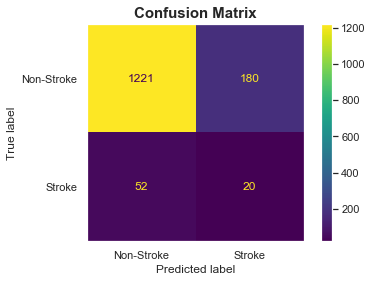

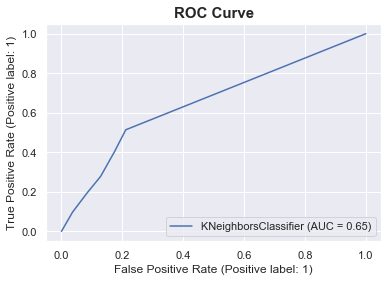

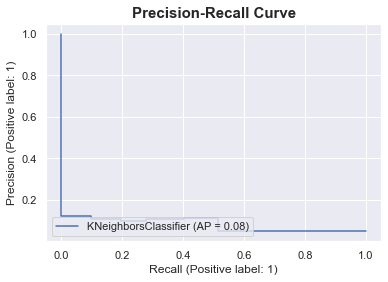

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1401
           1       0.14      0.29      0.19        72

    accuracy                           0.88      1473
   macro avg       0.55      0.60      0.56      1473
weighted avg       0.92      0.88      0.90      1473



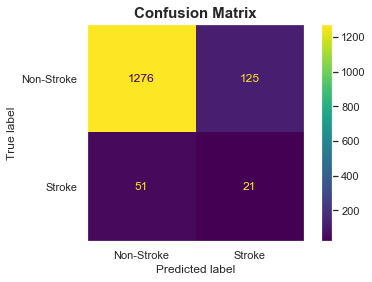

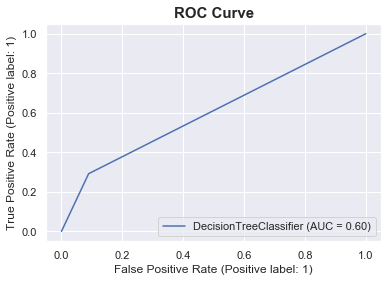

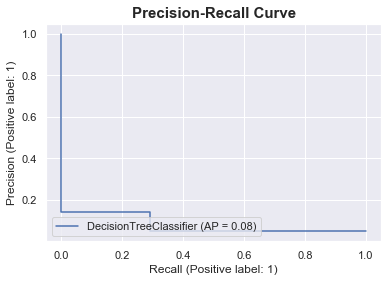

RF Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1401
           1       0.17      0.11      0.13        72

    accuracy                           0.93      1473
   macro avg       0.56      0.54      0.55      1473
weighted avg       0.92      0.93      0.92      1473



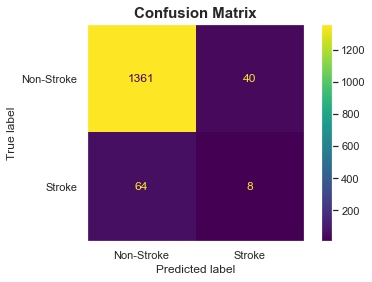

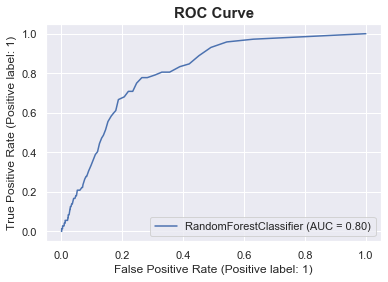

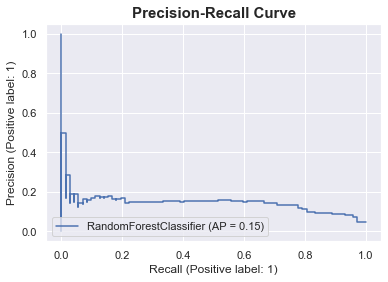

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1401
           1       0.14      0.83      0.24        72

    accuracy                           0.74      1473
   macro avg       0.57      0.79      0.54      1473
weighted avg       0.95      0.74      0.82      1473



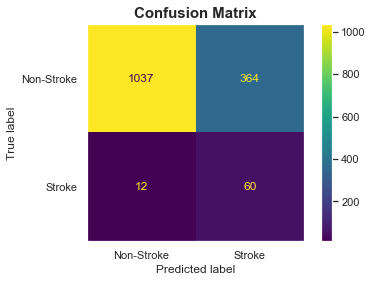

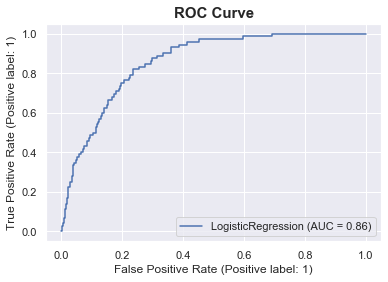

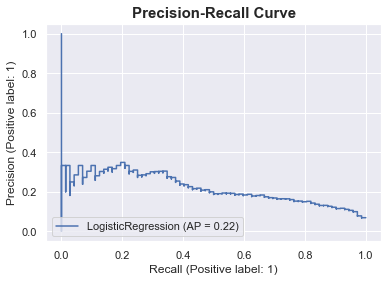

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.36      0.52      1401
           1       0.07      0.96      0.13        72

    accuracy                           0.38      1473
   macro avg       0.53      0.66      0.33      1473
weighted avg       0.95      0.38      0.50      1473



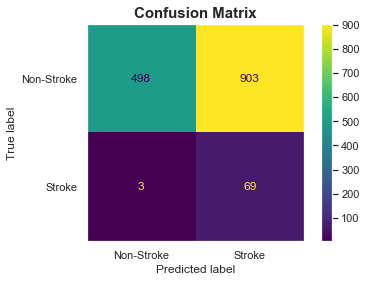

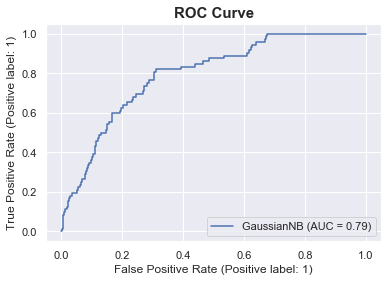

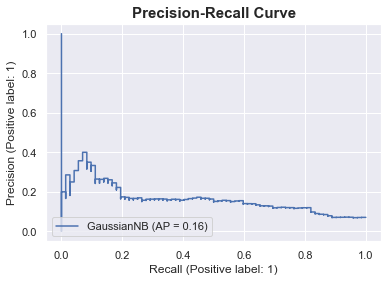

MLP Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1401
           1       0.16      0.28      0.20        72

    accuracy                           0.89      1473
   macro avg       0.56      0.60      0.57      1473
weighted avg       0.92      0.89      0.91      1473



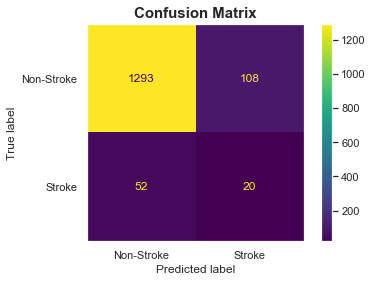

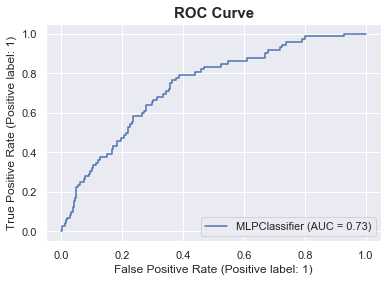

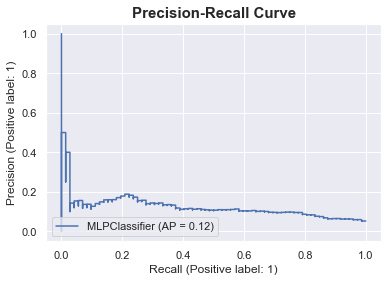

In [51]:
model_pipeline(X_resampled, X_test, y_resampled, y_test)

Precision went up very slightly for GNB as now we have 903 FPs compared to 920 FPs (before SMOTE) and recall stayed the same. We will keep the resampled training data and we will try a different strategy to improve precision significantly.

# Feature Extraction

In [52]:
from sklearn.decomposition import PCA
pca = PCA(.99)
pca.fit(X_resampled)
train_pca = pca.transform(X_resampled)
test_pca = pca.transform(X_test)
print("Shape of resampled training data:", X_resampled.shape)
print("Shape of transformed training data :", train_pca.shape)
print("Shape of transformed testing data :", test_pca.shape)

Shape of resampled training data: (6596, 20)
Shape of transformed training data : (6596, 15)
Shape of transformed testing data : (1473, 15)


Let's rerun the classifiers after dimensionality reduction.

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1401
           1       0.14      0.42      0.21        72

    accuracy                           0.85      1473
   macro avg       0.55      0.64      0.56      1473
weighted avg       0.93      0.85      0.88      1473



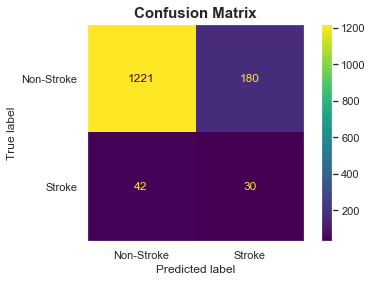

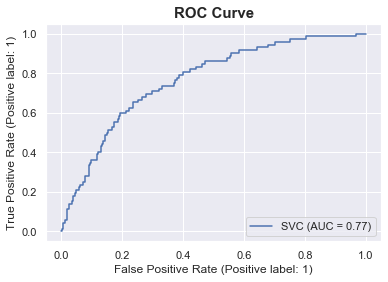

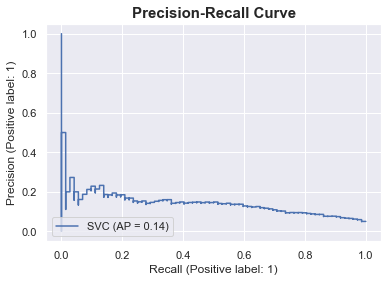

KNN Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1401
           1       0.10      0.28      0.15        72

    accuracy                           0.84      1473
   macro avg       0.53      0.57      0.53      1473
weighted avg       0.92      0.84      0.88      1473



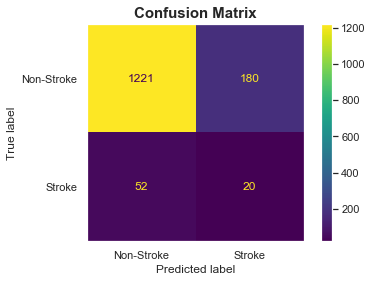

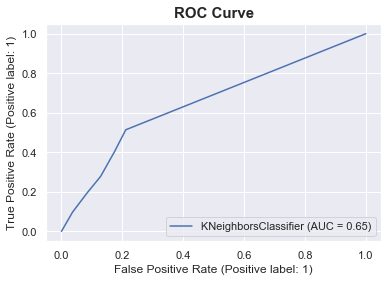

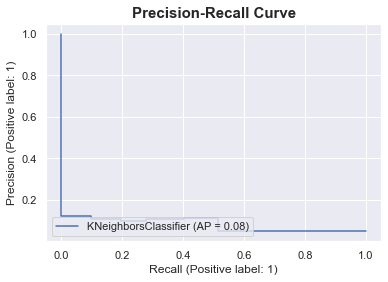

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1401
           1       0.15      0.26      0.19        72

    accuracy                           0.89      1473
   macro avg       0.55      0.59      0.56      1473
weighted avg       0.92      0.89      0.90      1473



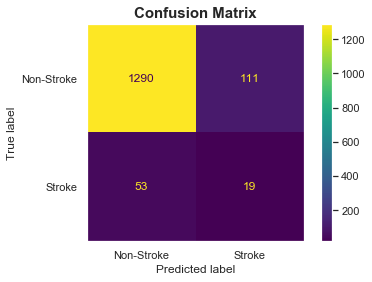

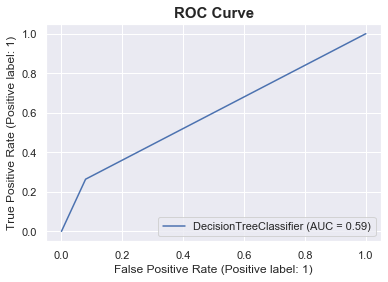

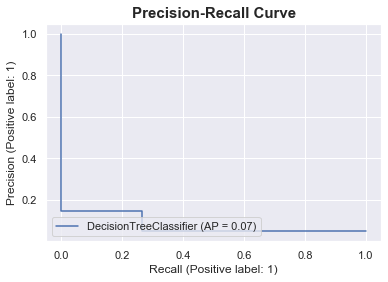

RF Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1401
           1       0.14      0.15      0.15        72

    accuracy                           0.91      1473
   macro avg       0.55      0.55      0.55      1473
weighted avg       0.92      0.91      0.92      1473



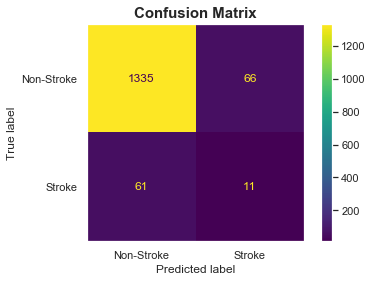

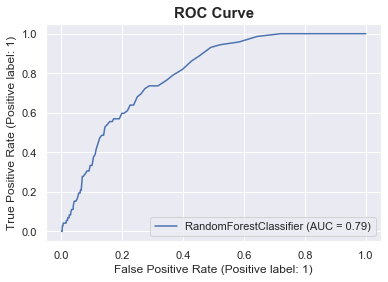

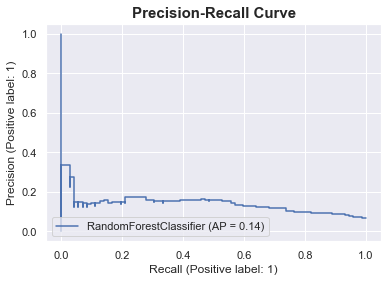

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1401
           1       0.14      0.83      0.24        72

    accuracy                           0.74      1473
   macro avg       0.57      0.79      0.54      1473
weighted avg       0.95      0.74      0.82      1473



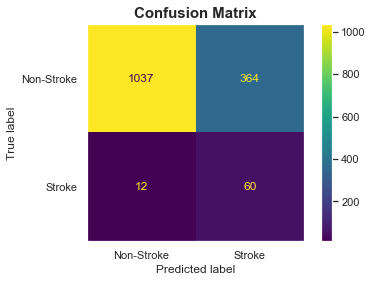

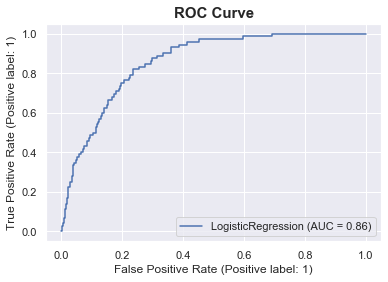

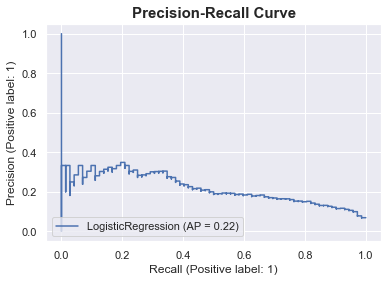

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      1401
           1       0.10      0.85      0.18        72

    accuracy                           0.61      1473
   macro avg       0.54      0.72      0.46      1473
weighted avg       0.94      0.61      0.72      1473



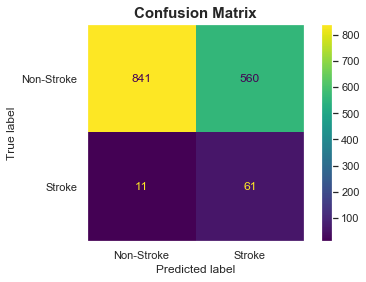

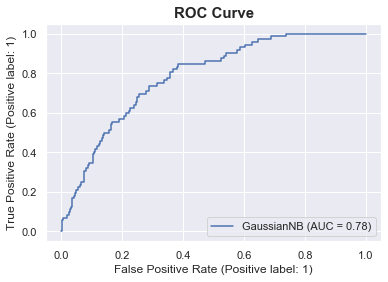

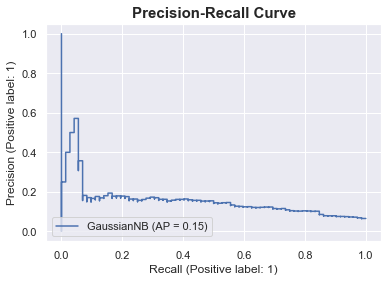

MLP Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1401
           1       0.13      0.22      0.16        72

    accuracy                           0.89      1473
   macro avg       0.54      0.57      0.55      1473
weighted avg       0.92      0.89      0.90      1473



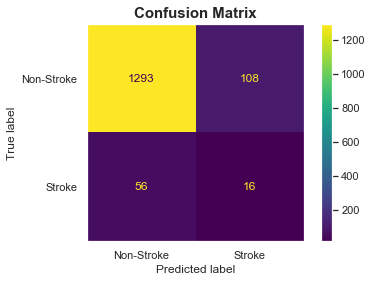

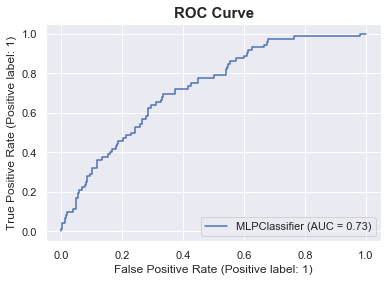

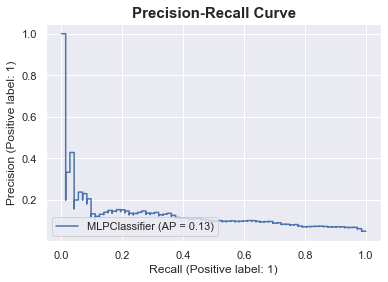

In [53]:
model_pipeline(train_pca, test_pca, y_resampled, y_test)

Dimensionality reduction doubled the precision but significantly reduced the recall (from 96% to 83%). So, it makes the classifier perform worse and will not be used in model building. 

# Anomaly Detection

Let's try Outlier Detection. We will start with Isolation Forest.

In [54]:
from sklearn.ensemble import IsolationForest

forr = IsolationForest(contamination=0.01)
forr_outliers = forr.fit_predict(X_resampled)

In [55]:
print(Counter(forr_outliers))

Counter({1: 6530, -1: 66})


We have identified observations in the resampled training set that are outliers. Let's remove them.

In [56]:
X_removed = X_resampled[np.where(forr_outliers == 1, True, False)]

In [57]:
X_removed.shape

(6530, 20)

In [58]:
y_removed = y_resampled[np.where(forr_outliers == 1, True, False)]

In [59]:
y_removed.shape

(6530,)

In [60]:
Counter(y_removed)

Counter({0: 3256, 1: 3274})

Now, let's rerun the models and evaluate their performance after having removed outliers. 

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1401
           1       0.15      0.43      0.22        72

    accuracy                           0.85      1473
   macro avg       0.56      0.65      0.57      1473
weighted avg       0.93      0.85      0.88      1473



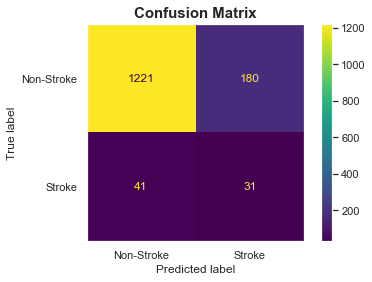

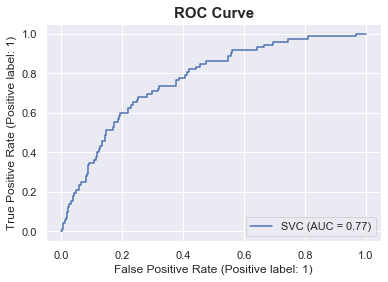

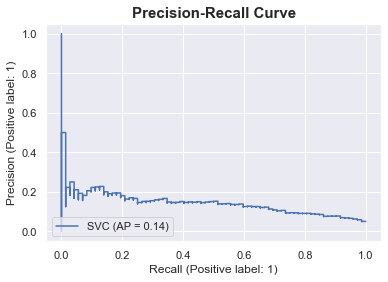

KNN Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1401
           1       0.10      0.28      0.15        72

    accuracy                           0.84      1473
   macro avg       0.53      0.57      0.53      1473
weighted avg       0.92      0.84      0.88      1473



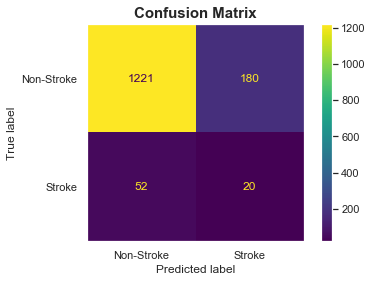

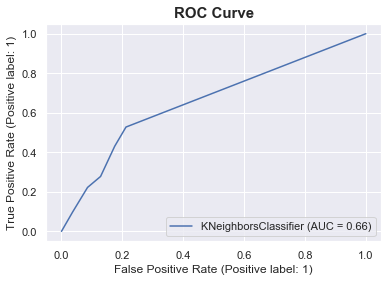

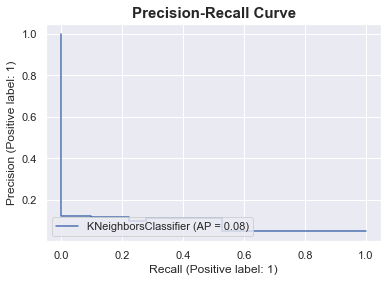

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1401
           1       0.16      0.33      0.21        72

    accuracy                           0.88      1473
   macro avg       0.56      0.62      0.57      1473
weighted avg       0.92      0.88      0.90      1473



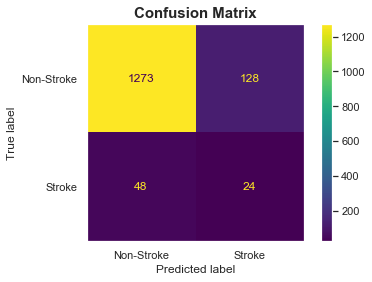

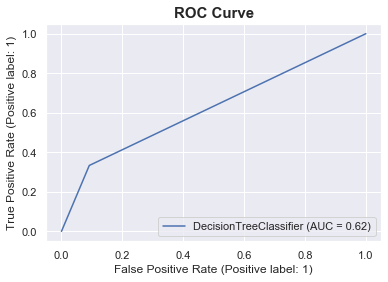

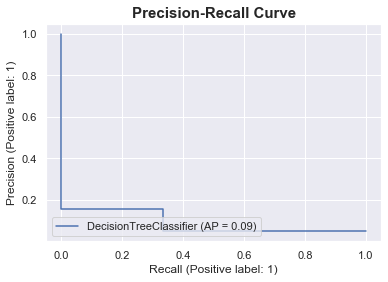

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1401
           1       0.13      0.08      0.10        72

    accuracy                           0.93      1473
   macro avg       0.54      0.53      0.53      1473
weighted avg       0.91      0.93      0.92      1473



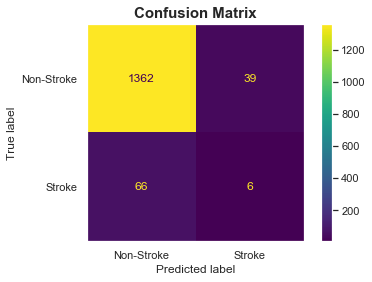

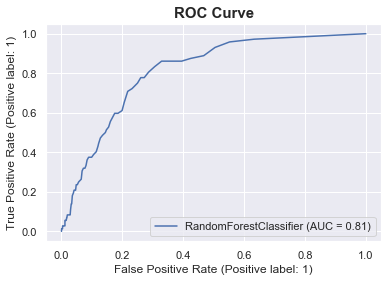

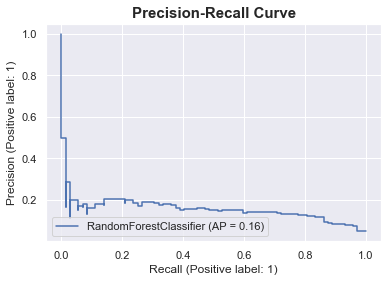

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1401
           1       0.14      0.83      0.24        72

    accuracy                           0.74      1473
   macro avg       0.56      0.79      0.54      1473
weighted avg       0.95      0.74      0.82      1473



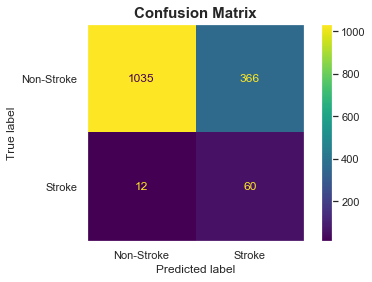

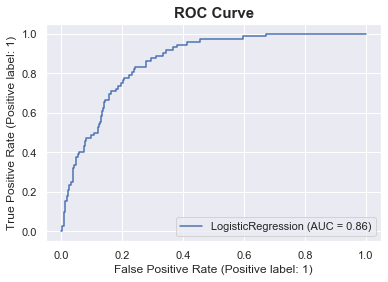

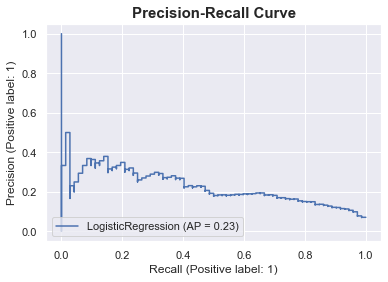

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.36      0.52      1401
           1       0.07      0.96      0.13        72

    accuracy                           0.38      1473
   macro avg       0.53      0.66      0.33      1473
weighted avg       0.95      0.38      0.50      1473



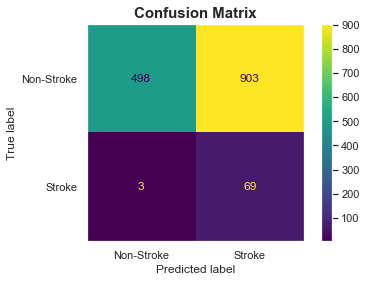

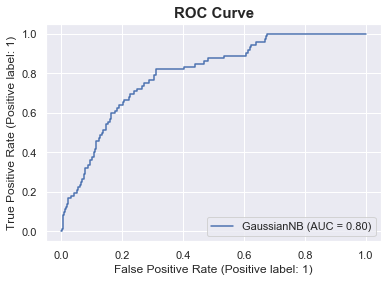

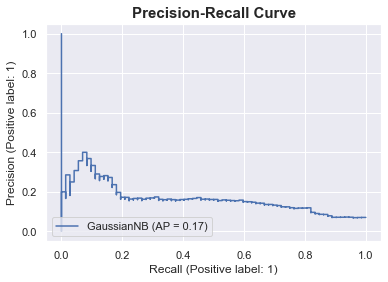

MLP Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1401
           1       0.17      0.29      0.22        72

    accuracy                           0.90      1473
   macro avg       0.57      0.61      0.58      1473
weighted avg       0.92      0.90      0.91      1473



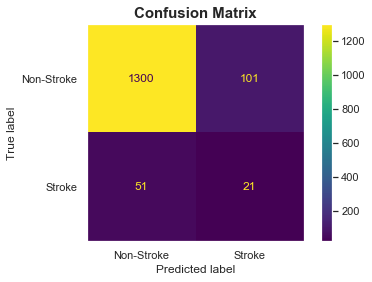

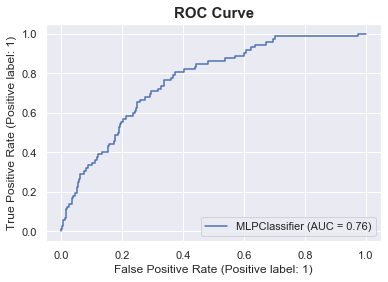

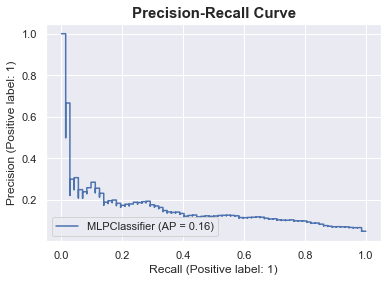

In [61]:
model_pipeline(X_removed, X_test, y_removed, y_test)

The best classifiers (GNB and Logistic Regression) were unaffected after removing outliers using Isolation Forest.

Let's try another outlier detection method, DBSCAN.

In [62]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.3, min_samples = 5)
db_outliers = dbscan.fit_predict(X_resampled)

In [63]:
print(Counter(db_outliers))

Counter({-1: 4695, 35: 126, 1: 112, 4: 82, 5: 80, 0: 66, 34: 64, 16: 60, 10: 58, 65: 55, 18: 42, 36: 39, 26: 38, 51: 33, 2: 30, 17: 29, 22: 26, 30: 24, 14: 22, 19: 20, 89: 20, 81: 18, 43: 16, 46: 16, 3: 14, 40: 14, 42: 14, 57: 14, 11: 13, 50: 13, 79: 13, 38: 12, 33: 12, 39: 12, 55: 12, 21: 11, 6: 11, 24: 11, 62: 11, 15: 10, 47: 10, 63: 10, 64: 10, 93: 10, 77: 10, 32: 9, 111: 9, 29: 9, 49: 9, 61: 9, 70: 9, 90: 9, 92: 9, 7: 8, 45: 8, 25: 8, 37: 8, 110: 8, 52: 8, 53: 8, 54: 8, 60: 8, 73: 8, 87: 8, 130: 8, 9: 7, 8: 7, 124: 7, 41: 7, 58: 7, 68: 7, 72: 7, 126: 7, 82: 7, 97: 7, 109: 7, 102: 7, 117: 7, 112: 7, 121: 6, 13: 6, 23: 6, 28: 6, 71: 6, 44: 6, 116: 6, 74: 6, 85: 6, 86: 6, 98: 6, 119: 6, 100: 6, 104: 6, 129: 6, 137: 6, 27: 5, 69: 5, 59: 5, 12: 5, 67: 5, 83: 5, 20: 5, 66: 5, 120: 5, 48: 5, 56: 5, 133: 5, 75: 5, 96: 5, 76: 5, 78: 5, 80: 5, 136: 5, 106: 5, 115: 5, 84: 5, 128: 5, 123: 5, 88: 5, 91: 5, 94: 5, 105: 5, 113: 5, 127: 5, 95: 5, 107: 5, 99: 5, 101: 5, 118: 5, 103: 5, 108: 5, 132:

In [64]:
X_removed = X_resampled[np.where(db_outliers != -1, True, False)]

In [65]:
X_removed.shape

(1901, 20)

In [66]:
y_removed = y_resampled[np.where(db_outliers != -1, True, False)]

In [67]:
y_removed.shape

(1901,)

In [68]:
Counter(y_removed)

Counter({0: 480, 1: 1421})

SVM Classification Report
              precision    recall  f1-score   support

           0       1.00      0.33      0.50      1401
           1       0.07      1.00      0.13        72

    accuracy                           0.36      1473
   macro avg       0.54      0.66      0.31      1473
weighted avg       0.95      0.36      0.48      1473



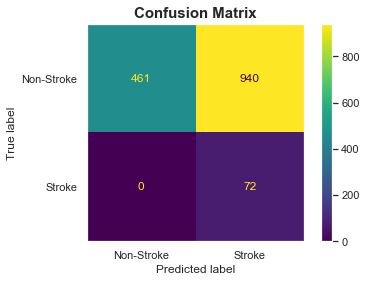

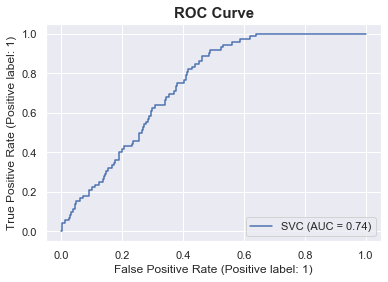

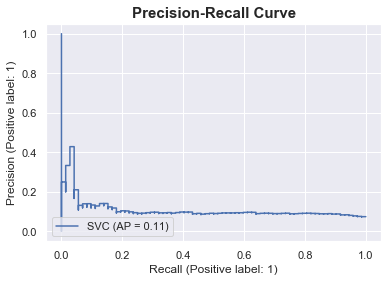

KNN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.40      0.57      1401
           1       0.07      0.90      0.13        72

    accuracy                           0.42      1473
   macro avg       0.53      0.65      0.35      1473
weighted avg       0.94      0.42      0.54      1473



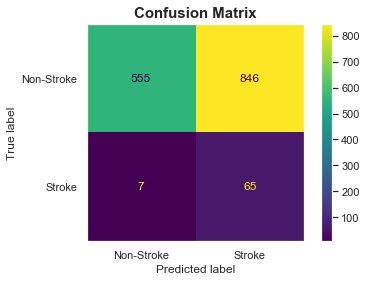

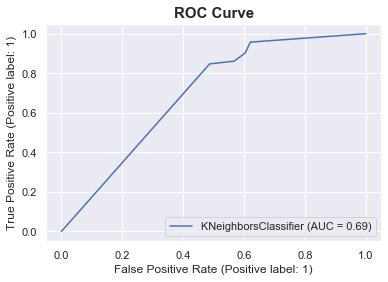

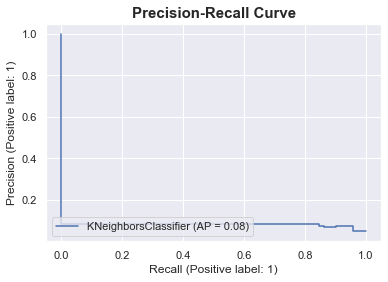

DT Classification Report
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      1401
           1       0.10      0.82      0.18        72

    accuracy                           0.63      1473
   macro avg       0.54      0.72      0.47      1473
weighted avg       0.94      0.63      0.73      1473



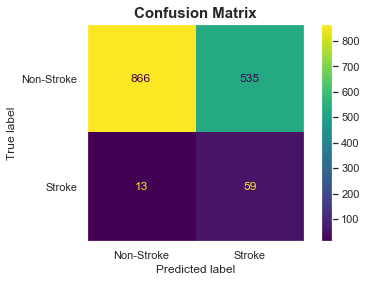

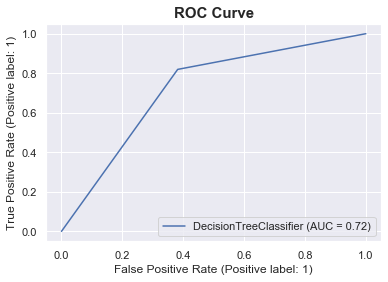

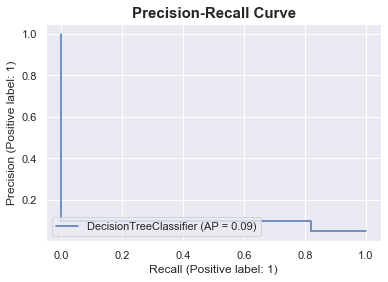

RF Classification Report
              precision    recall  f1-score   support

           0       1.00      0.49      0.66      1401
           1       0.09      0.96      0.16        72

    accuracy                           0.52      1473
   macro avg       0.54      0.73      0.41      1473
weighted avg       0.95      0.52      0.64      1473



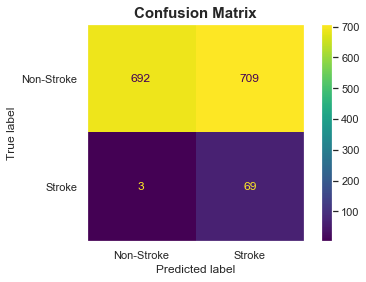

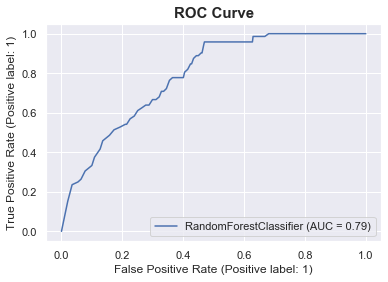

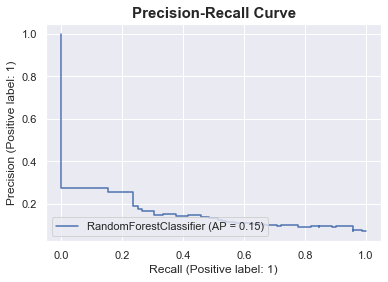

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       1.00      0.37      0.54      1401
           1       0.08      1.00      0.14        72

    accuracy                           0.40      1473
   macro avg       0.54      0.69      0.34      1473
weighted avg       0.95      0.40      0.52      1473



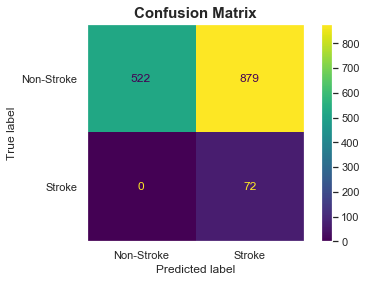

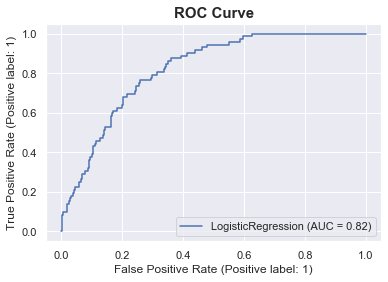

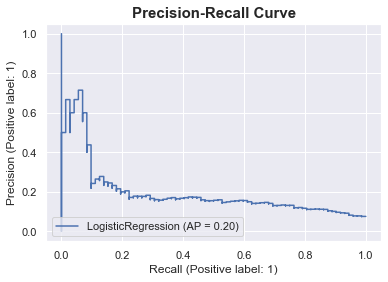

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.38      0.55      1401
           1       0.07      0.96      0.14        72

    accuracy                           0.40      1473
   macro avg       0.53      0.67      0.34      1473
weighted avg       0.95      0.40      0.53      1473



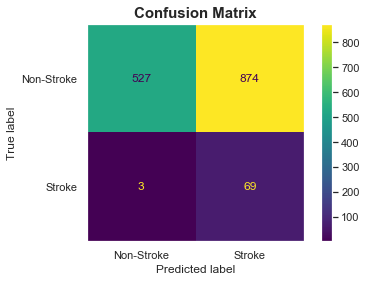

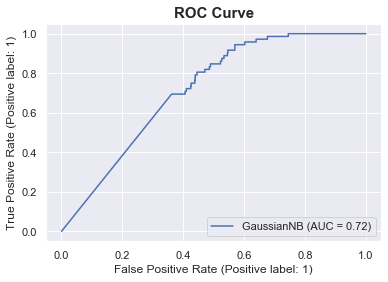

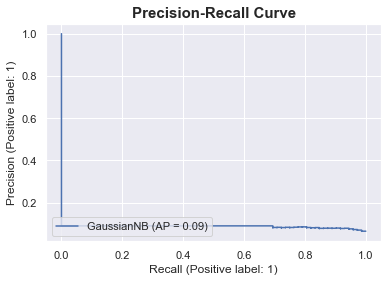

MLP Classification Report
              precision    recall  f1-score   support

           0       0.99      0.46      0.63      1401
           1       0.08      0.94      0.15        72

    accuracy                           0.49      1473
   macro avg       0.54      0.70      0.39      1473
weighted avg       0.95      0.49      0.61      1473



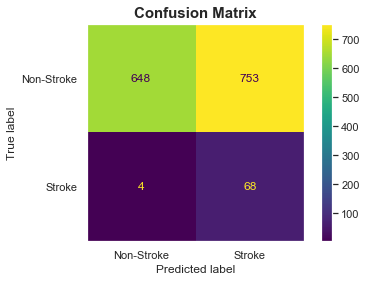

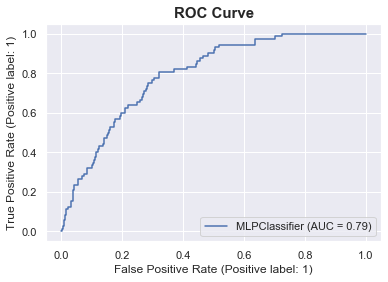

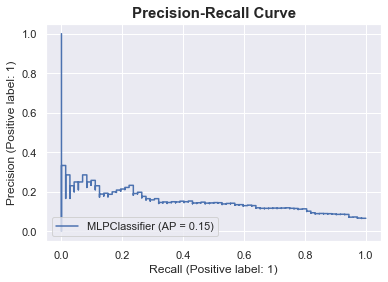

In [69]:
model_pipeline(X_removed, X_test, y_removed, y_test)

Removing outliers using DBSCAN significantly improves the stroke class recall for all algorithms, which is a good sign. Precision of the stroke class however is still very low and should be improved. SVM gave perfect recall but precision is still low.

DBSCAN seems to improve the recall significantly for all algorithms. Let's see if other outlier removal methods do the same by creating an outlier removal pipeline. 

In [70]:
def outlier_pipeline(X,y, method, eps=0.3, min_samples=5, contam_iso=0.01,
                    n_neighbors=2, contam_lof=0.01, contam_cov=0.1):
    
    if method == 'DBSCAN':
        dbscan = DBSCAN(eps, min_samples)
        print(dbscan.get_params())
        print()
        outliers = dbscan.fit_predict(X)
        X_rem = X[np.where(outliers != -1, True, False)]
        y_rem = y[np.where(outliers != -1, True, False)]
        
    if method == 'Isolation Forest':
        iso = IsolationForest(contamination=contam_iso)
        print(iso.get_params())
        print()
        outliers = iso.fit_predict(X)
        X_rem = X[np.where(outliers == 1, True, False)]
        y_rem = y[np.where(outliers == 1, True, False)]
        
    if method == 'LOF':
        lof = LocalOutlierFactor(n_neighbors, contamination=contam_lof)
        print(lof.get_params())
        print()
        outliers = lof.fit_predict(X)
        X_rem = X[np.where(outliers == 1, True, False)]
        y_rem = y[np.where(outliers == 1, True, False)]
   
    if method == 'Robust Covariance':
        cov = EllipticEnvelope(contamination=contam_cov)
        print(cov.get_params())
        print()
        outliers = cov.fit_predict(X)
        X_rem = X[np.where(outliers == 1, True, False)]
        y_rem = y[np.where(outliers == 1, True, False)]
      
    if method == 'One-Class SVM':
        svm = OneClassSVM()
        print(svm.get_params())
        print()
        outliers = svm.fit_predict(X)
        X_rem = X[np.where(outliers == 1, True, False)]
        y_rem = y[np.where(outliers == 1, True, False)]
    
        
    print('Counts of each label after anomaly detection algorithm is applied:', 
          Counter(outliers))    
    print('Shape of training set before outlier removal:', X.shape)
    print('Shape of training set after outlier removal:', X_rem.shape)
    print('Number of labels after outlier removal:', len(y_rem))
    print('Counts of the 2 classes before outlier removal:', Counter(y))
    print('Counts of the 2 classes after outlier removal:', Counter(y_rem))
    print()
    
    return X_rem, y_rem
        
    
   
    

In [71]:
X_removed_db, y_removed_db = outlier_pipeline(X_resampled,y_resampled,'DBSCAN')
X_removed_iso, y_removed_iso = outlier_pipeline(X_resampled,y_resampled,'Isolation Forest')
X_removed_lof, y_removed_lof = outlier_pipeline(X_resampled,y_resampled,'LOF')
X_removed_cov, y_removed_cov = outlier_pipeline(X_resampled,y_resampled,'Robust Covariance')
X_removed_svm, y_removed_svm = outlier_pipeline(X_resampled,y_resampled,'One-Class SVM')

{'algorithm': 'auto', 'eps': 0.3, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 5, 'n_jobs': None, 'p': None}

Counts of each label after anomaly detection algorithm is applied: Counter({-1: 4695, 35: 126, 1: 112, 4: 82, 5: 80, 0: 66, 34: 64, 16: 60, 10: 58, 65: 55, 18: 42, 36: 39, 26: 38, 51: 33, 2: 30, 17: 29, 22: 26, 30: 24, 14: 22, 19: 20, 89: 20, 81: 18, 43: 16, 46: 16, 3: 14, 40: 14, 42: 14, 57: 14, 11: 13, 50: 13, 79: 13, 38: 12, 33: 12, 39: 12, 55: 12, 21: 11, 6: 11, 24: 11, 62: 11, 15: 10, 47: 10, 63: 10, 64: 10, 93: 10, 77: 10, 32: 9, 111: 9, 29: 9, 49: 9, 61: 9, 70: 9, 90: 9, 92: 9, 7: 8, 45: 8, 25: 8, 37: 8, 110: 8, 52: 8, 53: 8, 54: 8, 60: 8, 73: 8, 87: 8, 130: 8, 9: 7, 8: 7, 124: 7, 41: 7, 58: 7, 68: 7, 72: 7, 126: 7, 82: 7, 97: 7, 109: 7, 102: 7, 117: 7, 112: 7, 121: 6, 13: 6, 23: 6, 28: 6, 71: 6, 44: 6, 116: 6, 74: 6, 85: 6, 86: 6, 98: 6, 119: 6, 100: 6, 104: 6, 129: 6, 137: 6, 27: 5, 69: 5, 59: 5, 12: 5, 67: 5, 83: 5, 20: 5, 66: 5, 120: 

In [72]:
def summary_pipeline(X_tr, X_ts, y_tr, y_ts):
    classifiers = [SVC(), 
                   KNeighborsClassifier(),
                   DecisionTreeClassifier(),
                   RandomForestClassifier(),
                   LogisticRegression(),
                   GaussianNB(),
                   MLPClassifier()
                  ]


    result_table = pd.DataFrame(columns=['classifiers','recall','precision','f1-score','auc','ap'])


    for clf in classifiers:
        clf.fit(X_tr, y_tr)
        preds = clf.predict(X_ts)
        recall = recall_score(y_ts,  preds)
        precision = precision_score(y_ts,  preds)
        f1 = f1_score(y_ts,  preds)
        auc = roc_auc_score(y_ts, preds)
        ap = average_precision_score(y_ts, preds)
        
        tnr = recall_score(y_ts, preds, pos_label = 0)

        result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                            'recall':recall, 
                                            'precision':precision,
                                            'f1-score':f1,
                                            'auc':auc,
                                            'ap':ap,
                                           'tnr':tnr}, ignore_index=True)

    result_table.set_index('classifiers', inplace=True)
    
    return result_table

## DBSCAN 

SVM Classification Report
              precision    recall  f1-score   support

           0       1.00      0.33      0.50      1401
           1       0.07      1.00      0.13        72

    accuracy                           0.36      1473
   macro avg       0.54      0.66      0.31      1473
weighted avg       0.95      0.36      0.48      1473



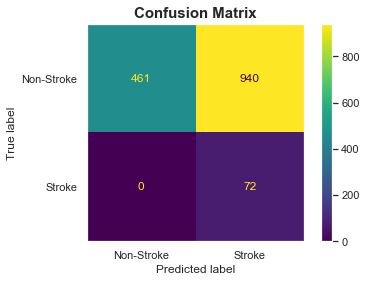

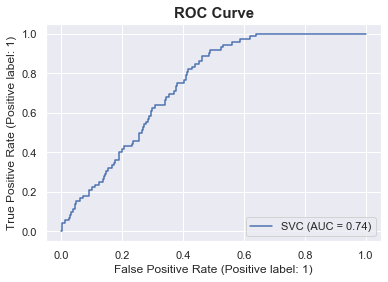

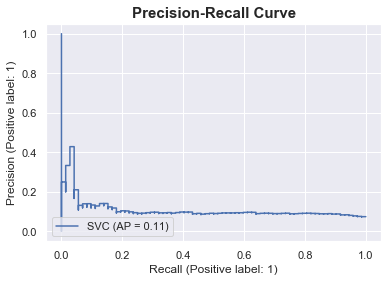

KNN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.40      0.57      1401
           1       0.07      0.90      0.13        72

    accuracy                           0.42      1473
   macro avg       0.53      0.65      0.35      1473
weighted avg       0.94      0.42      0.54      1473



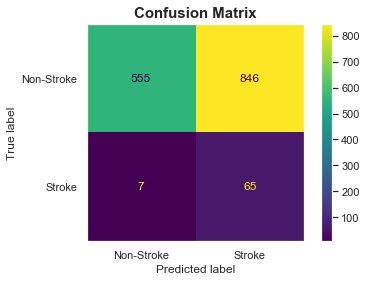

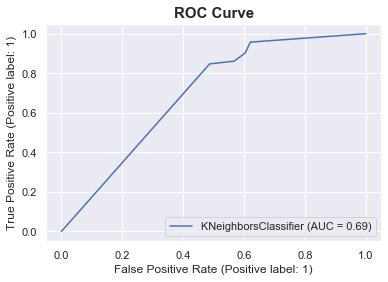

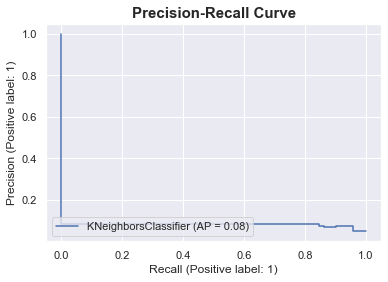

DT Classification Report
              precision    recall  f1-score   support

           0       0.98      0.63      0.76      1401
           1       0.10      0.79      0.17        72

    accuracy                           0.63      1473
   macro avg       0.54      0.71      0.47      1473
weighted avg       0.94      0.63      0.74      1473



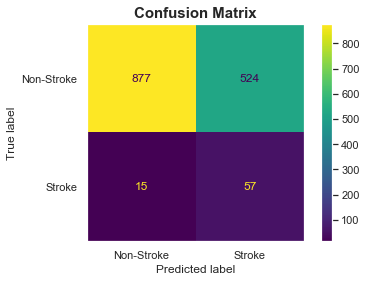

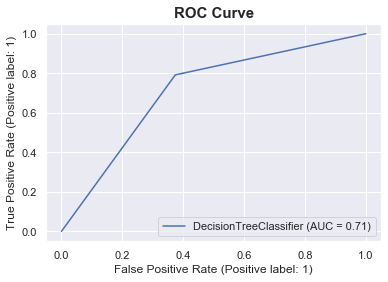

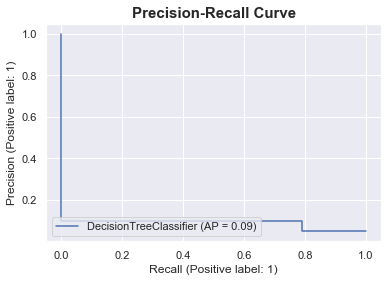

RF Classification Report
              precision    recall  f1-score   support

           0       0.99      0.50      0.67      1401
           1       0.09      0.94      0.16        72

    accuracy                           0.52      1473
   macro avg       0.54      0.72      0.41      1473
weighted avg       0.95      0.52      0.64      1473



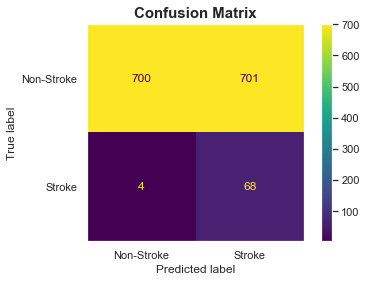

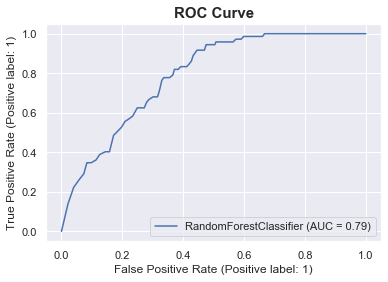

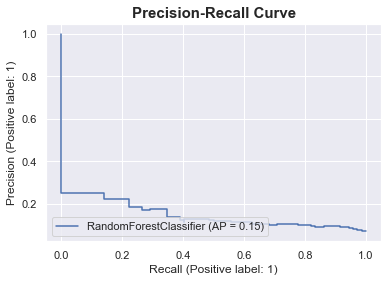

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       1.00      0.37      0.54      1401
           1       0.08      1.00      0.14        72

    accuracy                           0.40      1473
   macro avg       0.54      0.69      0.34      1473
weighted avg       0.95      0.40      0.52      1473



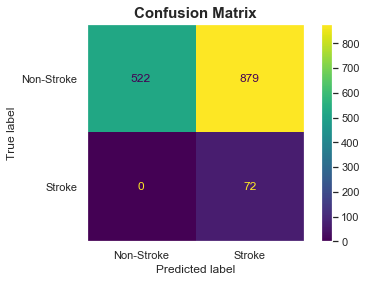

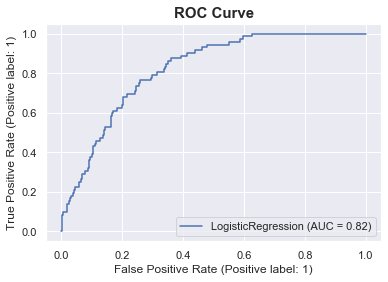

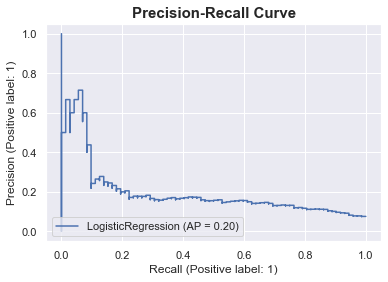

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.38      0.55      1401
           1       0.07      0.96      0.14        72

    accuracy                           0.40      1473
   macro avg       0.53      0.67      0.34      1473
weighted avg       0.95      0.40      0.53      1473



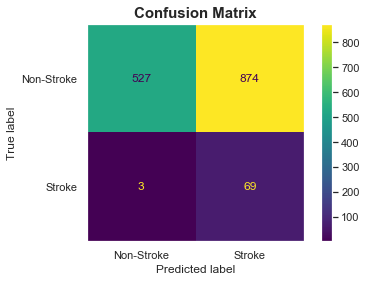

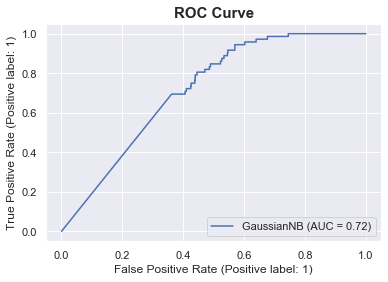

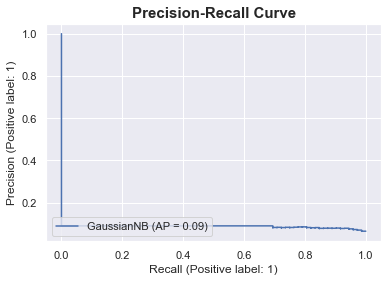

MLP Classification Report
              precision    recall  f1-score   support

           0       0.99      0.44      0.61      1401
           1       0.08      0.93      0.14        72

    accuracy                           0.46      1473
   macro avg       0.54      0.68      0.38      1473
weighted avg       0.95      0.46      0.58      1473



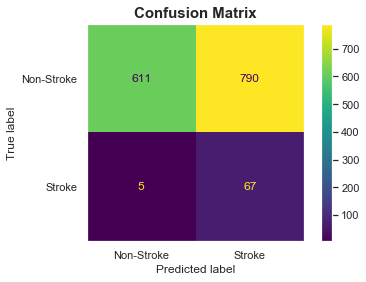

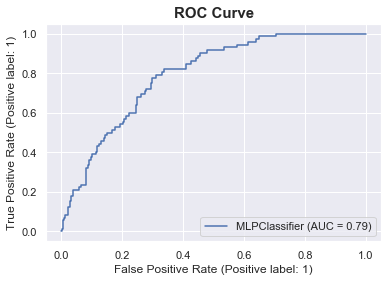

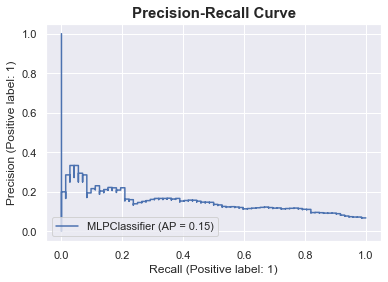

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     1.000000   0.071146  0.132841  0.664525  0.071146   
KNeighborsClassifier    0.902778   0.071350  0.132248  0.649462  0.069166   
DecisionTreeClassifier  0.805556   0.099145  0.176560  0.714698  0.089371   
RandomForestClassifier  0.958333   0.088918  0.162736  0.726847  0.087249   
LogisticRegression      1.000000   0.075710  0.140762  0.686296  0.075710   
GaussianNB              0.958333   0.073171  0.135961  0.667247  0.072159   
MLPClassifier           0.916667   0.077647  0.143167  0.678533  0.075250   

                             tnr  
classifiers                       
SVC                     0.329051  
KNeighborsClassifier    0.396146  
DecisionTreeClassifier  0.623840  
RandomForestClassifier  0.495360  
LogisticRegression      0.372591  
GaussianNB              0.376160  
MLPClassifier           0.440400

In [73]:
display(model_pipeline(X_removed_db, X_test, y_removed_db, y_test))
display(summary_pipeline(X_removed_db, X_test, y_removed_db, y_test))

## Isolation Forest

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1401
           1       0.14      0.42      0.21        72

    accuracy                           0.85      1473
   macro avg       0.55      0.64      0.56      1473
weighted avg       0.93      0.85      0.88      1473



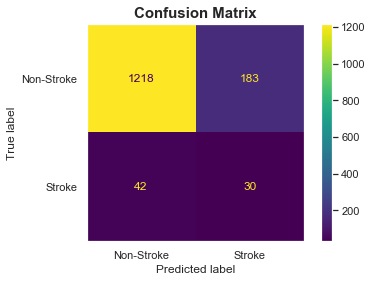

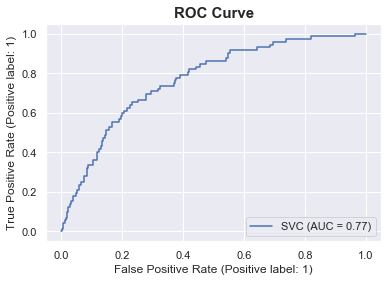

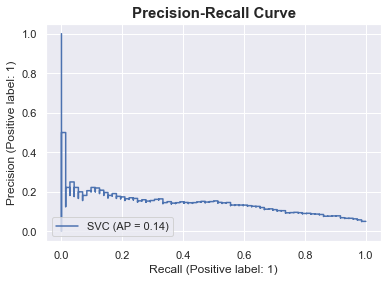

KNN Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1401
           1       0.10      0.28      0.15        72

    accuracy                           0.84      1473
   macro avg       0.53      0.57      0.53      1473
weighted avg       0.92      0.84      0.88      1473



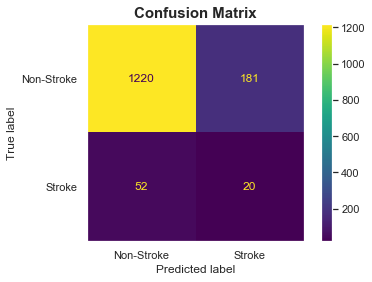

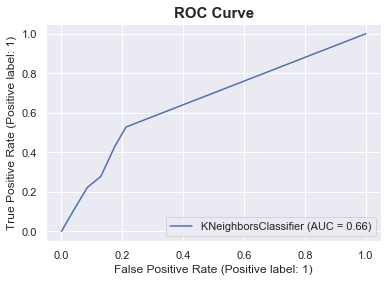

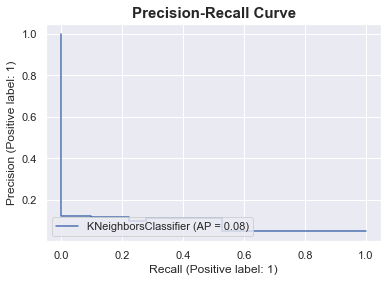

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1401
           1       0.14      0.29      0.19        72

    accuracy                           0.88      1473
   macro avg       0.55      0.60      0.56      1473
weighted avg       0.92      0.88      0.90      1473



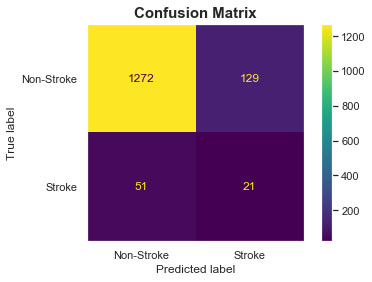

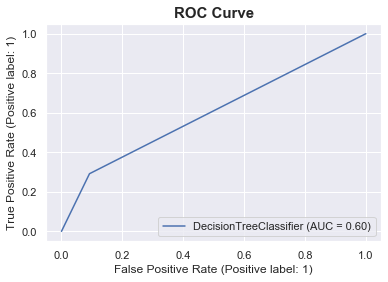

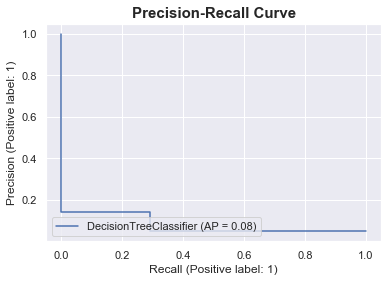

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1401
           1       0.15      0.10      0.12        72

    accuracy                           0.93      1473
   macro avg       0.55      0.53      0.54      1473
weighted avg       0.92      0.93      0.92      1473



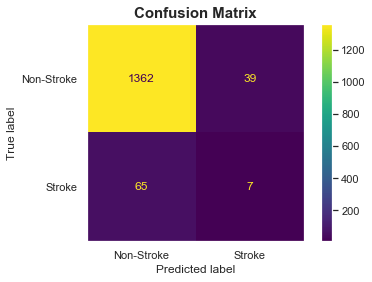

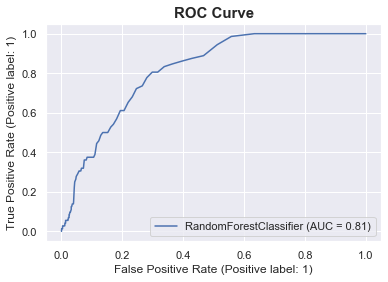

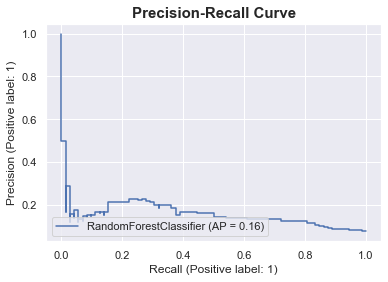

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1401
           1       0.14      0.83      0.24        72

    accuracy                           0.74      1473
   macro avg       0.56      0.79      0.54      1473
weighted avg       0.95      0.74      0.82      1473



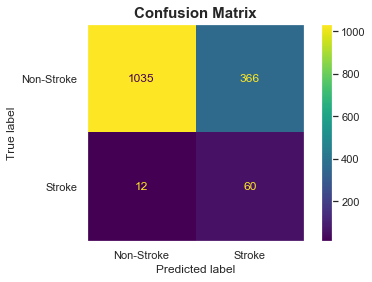

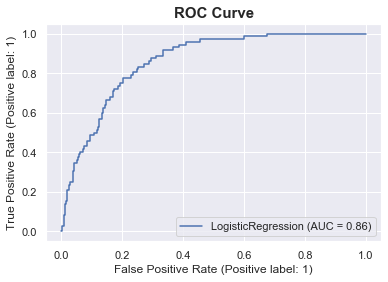

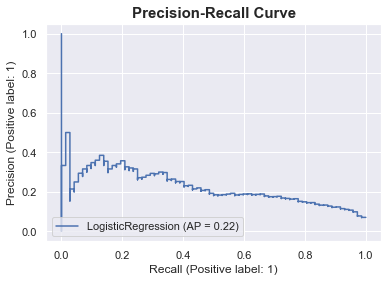

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.36      0.53      1401
           1       0.07      0.94      0.13        72

    accuracy                           0.39      1473
   macro avg       0.53      0.65      0.33      1473
weighted avg       0.95      0.39      0.51      1473



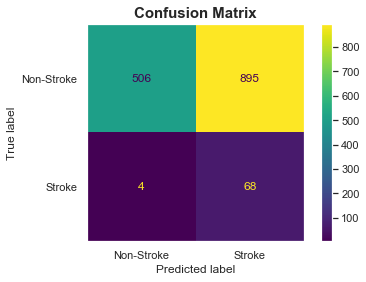

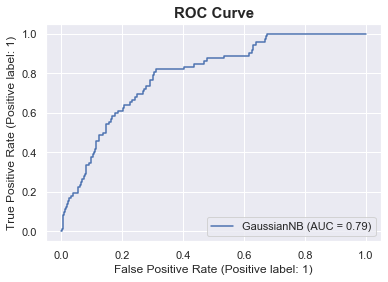

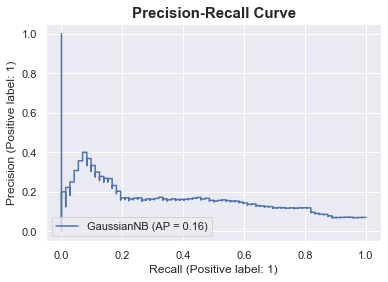

MLP Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1401
           1       0.15      0.22      0.18        72

    accuracy                           0.90      1473
   macro avg       0.56      0.58      0.56      1473
weighted avg       0.92      0.90      0.91      1473



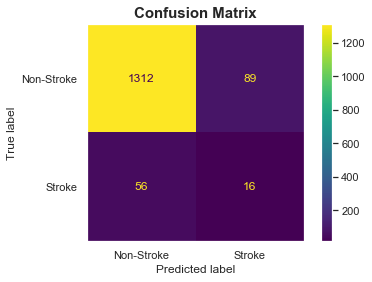

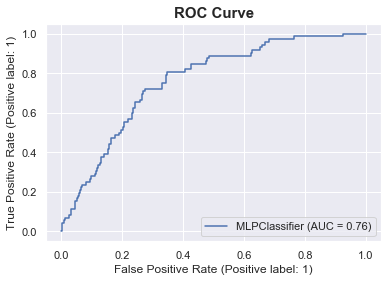

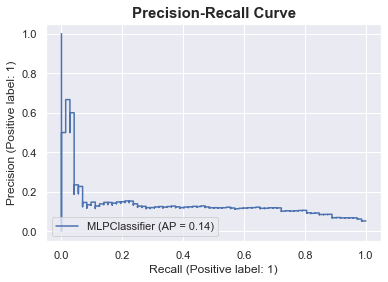

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.416667   0.140845  0.210526  0.643023  0.087199   
KNeighborsClassifier    0.277778   0.099502  0.146520  0.574292  0.062942   
DecisionTreeClassifier  0.291667   0.139073  0.188341  0.599438  0.075186   
RandomForestClassifier  0.111111   0.170213  0.134454  0.541637  0.062361   
LogisticRegression      0.833333   0.140845  0.240964  0.786046  0.125518   
GaussianNB              0.944444   0.070613  0.131401  0.652808  0.069405   
MLPClassifier           0.291667   0.177966  0.221053  0.611215  0.086530   

                             tnr  
classifiers                       
SVC                     0.869379  
KNeighborsClassifier    0.870807  
DecisionTreeClassifier  0.907209  
RandomForestClassifier  0.972163  
LogisticRegression      0.738758  
GaussianNB              0.361171  
MLPClassifier           0.930764

In [74]:
display(model_pipeline(X_removed_iso, X_test, y_removed_iso, y_test))
display(summary_pipeline(X_removed_iso, X_test, y_removed_iso, y_test))

## Local Outlier Factor (LOF)

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1401
           1       0.15      0.43      0.22        72

    accuracy                           0.85      1473
   macro avg       0.56      0.65      0.57      1473
weighted avg       0.93      0.85      0.88      1473



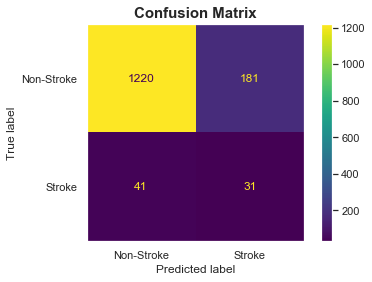

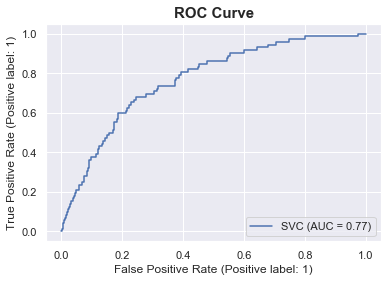

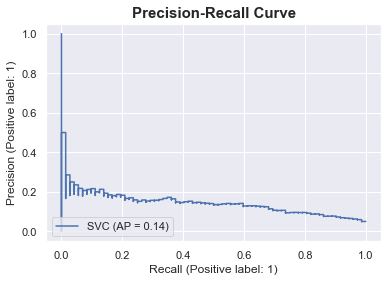

KNN Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1401
           1       0.10      0.28      0.14        72

    accuracy                           0.84      1473
   macro avg       0.53      0.57      0.53      1473
weighted avg       0.92      0.84      0.87      1473



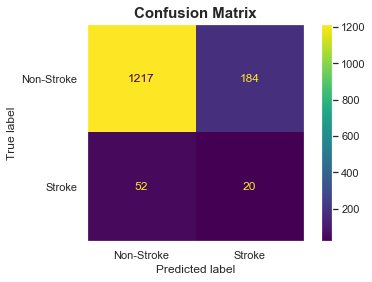

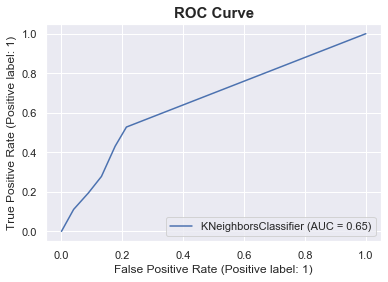

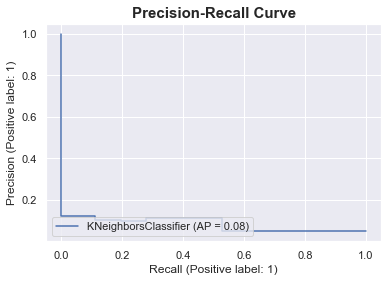

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1401
           1       0.14      0.32      0.20        72

    accuracy                           0.87      1473
   macro avg       0.55      0.61      0.56      1473
weighted avg       0.92      0.87      0.90      1473



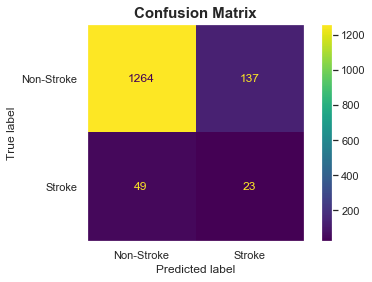

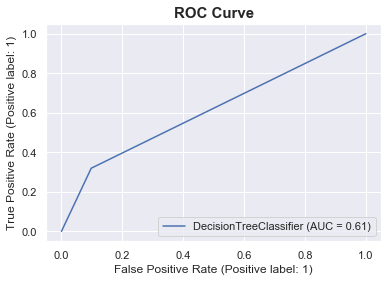

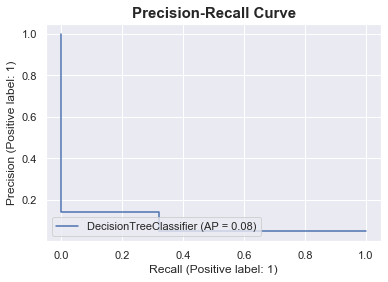

RF Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1401
           1       0.18      0.12      0.15        72

    accuracy                           0.93      1473
   macro avg       0.57      0.55      0.55      1473
weighted avg       0.92      0.93      0.92      1473



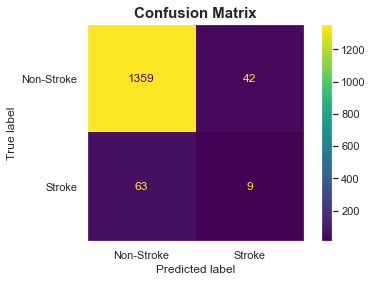

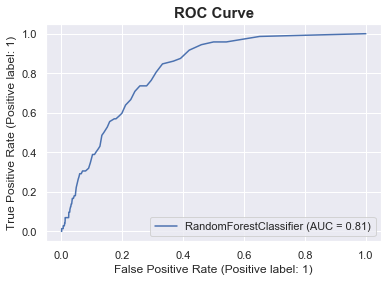

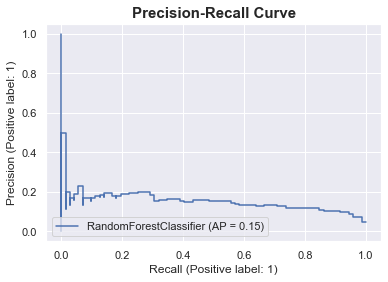

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1401
           1       0.14      0.83      0.24        72

    accuracy                           0.74      1473
   macro avg       0.56      0.79      0.54      1473
weighted avg       0.95      0.74      0.82      1473



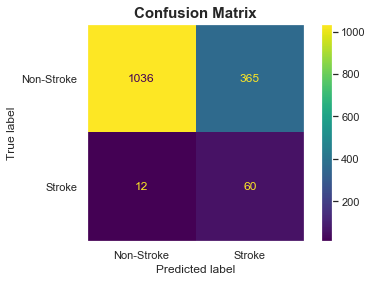

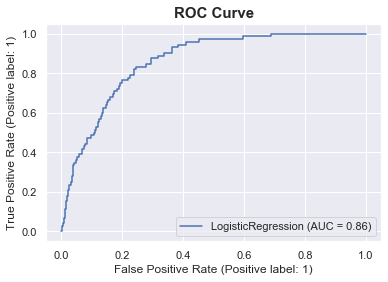

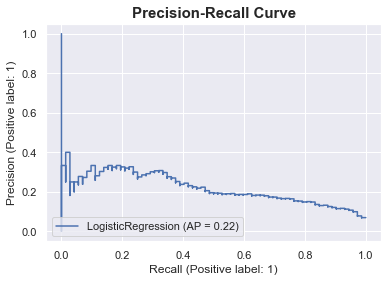

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.36      0.53      1401
           1       0.07      0.96      0.13        72

    accuracy                           0.39      1473
   macro avg       0.53      0.66      0.33      1473
weighted avg       0.95      0.39      0.51      1473



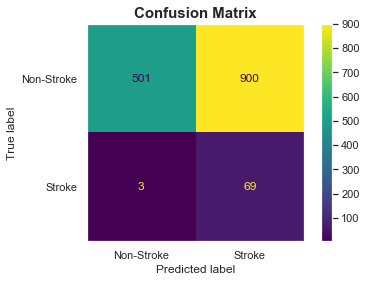

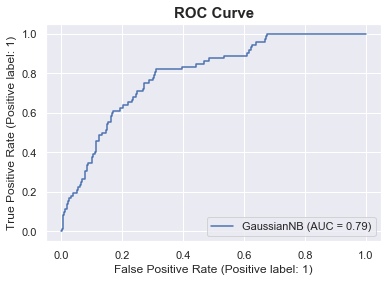

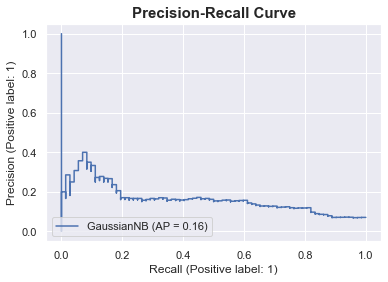

MLP Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1401
           1       0.15      0.22      0.18        72

    accuracy                           0.90      1473
   macro avg       0.55      0.58      0.56      1473
weighted avg       0.92      0.90      0.91      1473



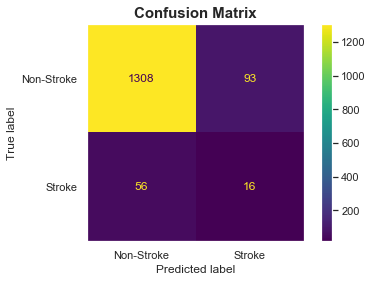

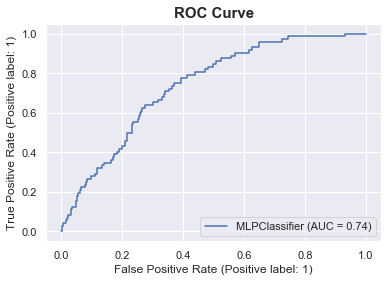

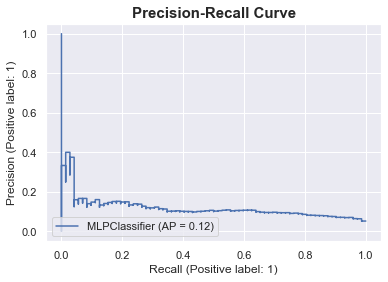

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.430556   0.146226  0.218310  0.650681  0.090793   
KNeighborsClassifier    0.277778   0.098039  0.144928  0.573222  0.062535   
DecisionTreeClassifier  0.277778   0.123457  0.170940  0.588211  0.069596   
RandomForestClassifier  0.125000   0.166667  0.142857  0.546440  0.063603   
LogisticRegression      0.833333   0.141176  0.241449  0.786403  0.125794   
GaussianNB              0.958333   0.071207  0.132565  0.657968  0.070277   
MLPClassifier           0.250000   0.137405  0.177340  0.584672  0.071011   

                             tnr  
classifiers                       
SVC                     0.870807  
KNeighborsClassifier    0.868665  
DecisionTreeClassifier  0.898644  
RandomForestClassifier  0.967880  
LogisticRegression      0.739472  
GaussianNB              0.357602  
MLPClassifier           0.919343

In [75]:
display(model_pipeline(X_removed_lof, X_test, y_removed_lof, y_test))
display(summary_pipeline(X_removed_lof, X_test, y_removed_lof, y_test))

## Robust Covariance

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1401
           1       0.12      0.46      0.19        72

    accuracy                           0.81      1473
   macro avg       0.55      0.64      0.54      1473
weighted avg       0.93      0.81      0.86      1473



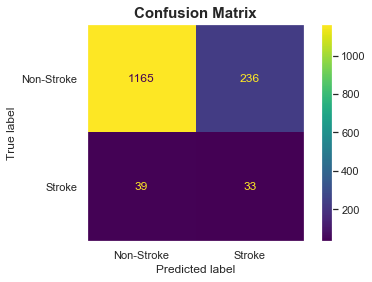

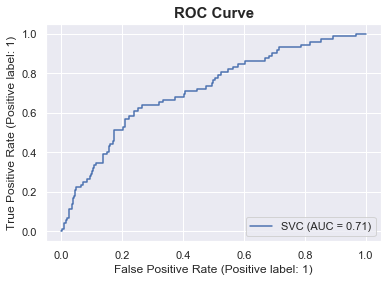

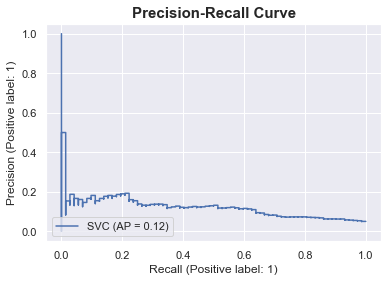

KNN Classification Report
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1401
           1       0.05      0.26      0.09        72

    accuracy                           0.74      1473
   macro avg       0.50      0.51      0.47      1473
weighted avg       0.91      0.74      0.81      1473



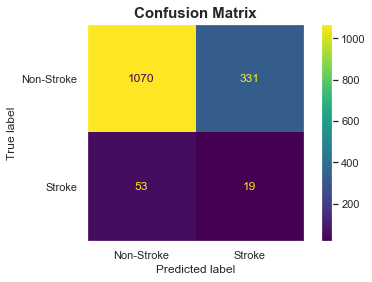

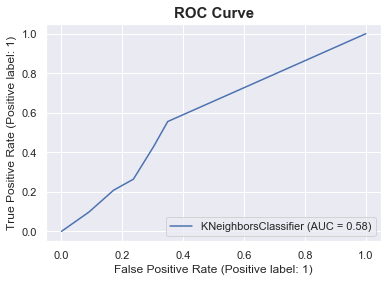

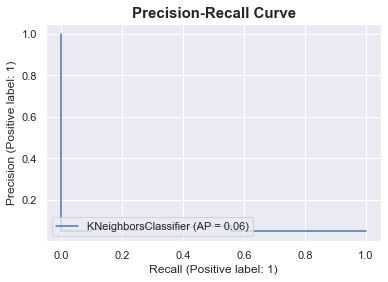

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1401
           1       0.14      0.32      0.20        72

    accuracy                           0.87      1473
   macro avg       0.55      0.61      0.56      1473
weighted avg       0.92      0.87      0.90      1473



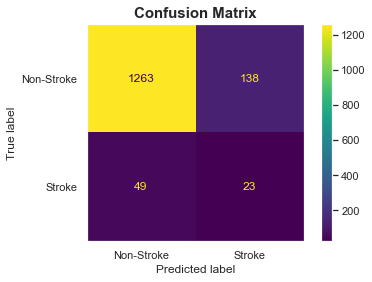

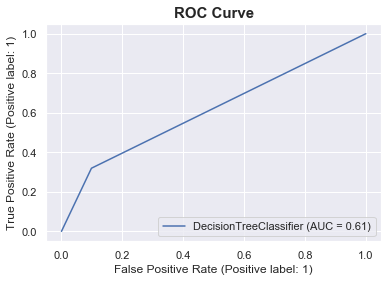

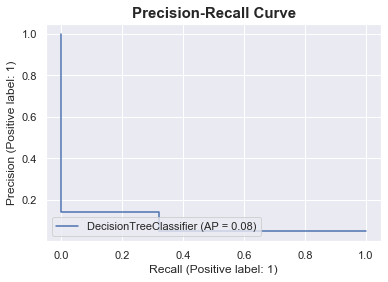

RF Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1401
           1       0.16      0.14      0.15        72

    accuracy                           0.92      1473
   macro avg       0.56      0.55      0.56      1473
weighted avg       0.92      0.92      0.92      1473



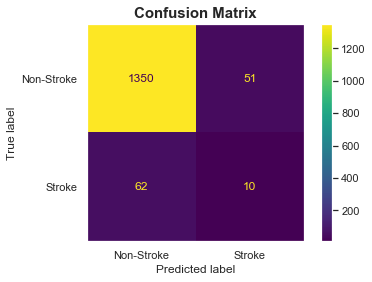

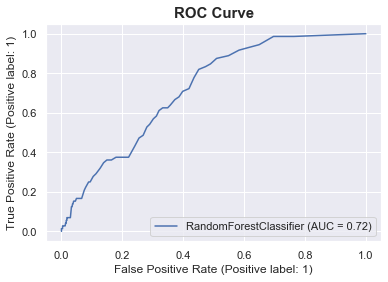

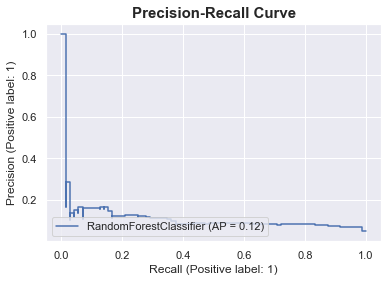

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1401
           1       0.13      0.82      0.23        72

    accuracy                           0.72      1473
   macro avg       0.56      0.77      0.53      1473
weighted avg       0.95      0.72      0.80      1473



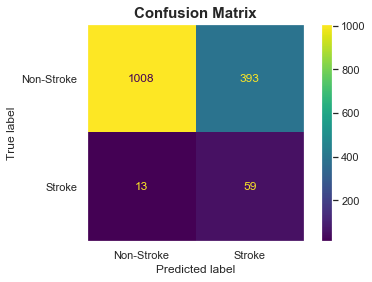

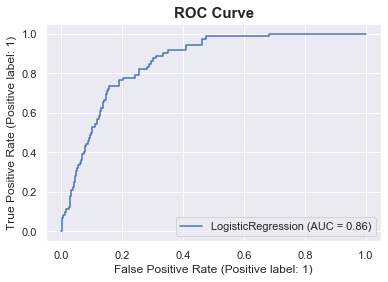

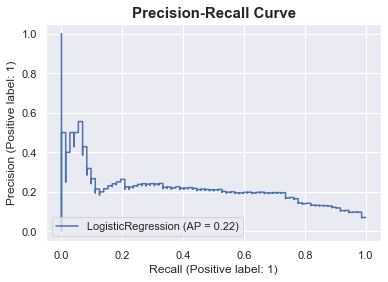

GNB Classification Report
              precision    recall  f1-score   support

           0       0.98      0.37      0.54      1401
           1       0.07      0.89      0.13        72

    accuracy                           0.40      1473
   macro avg       0.53      0.63      0.33      1473
weighted avg       0.94      0.40      0.52      1473



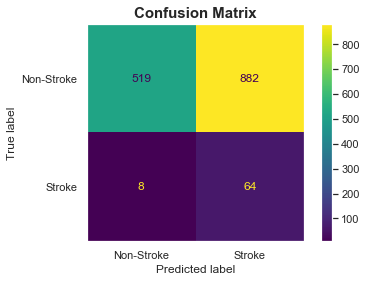

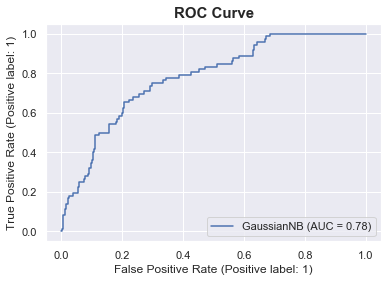

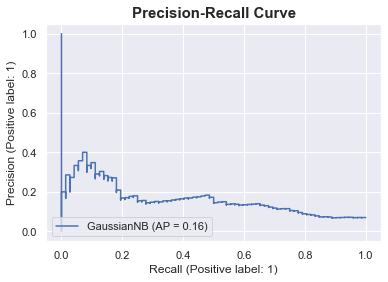

MLP Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1401
           1       0.08      0.24      0.12        72

    accuracy                           0.84      1473
   macro avg       0.52      0.55      0.52      1473
weighted avg       0.91      0.84      0.87      1473



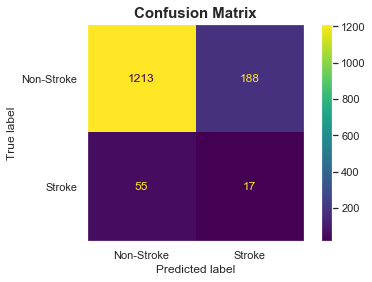

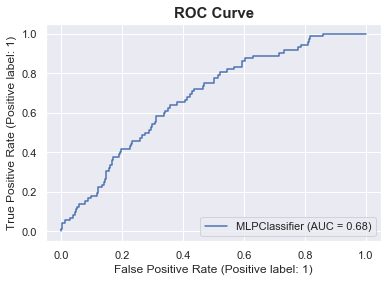

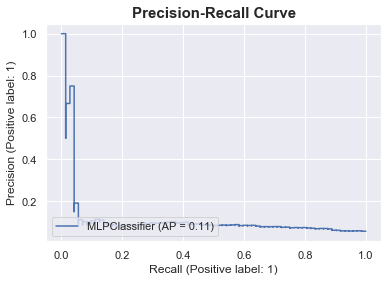

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.458333   0.122677  0.193548  0.644941  0.082703   
KNeighborsClassifier    0.263889   0.054286  0.090047  0.513815  0.050306   
DecisionTreeClassifier  0.347222   0.155280  0.214592  0.625074  0.085824   
RandomForestClassifier  0.125000   0.160714  0.140625  0.545726  0.062859   
LogisticRegression      0.819444   0.130531  0.225191  0.769465  0.115788   
GaussianNB              0.888889   0.067653  0.125737  0.629669  0.065567   
MLPClassifier           0.250000   0.081081  0.122449  0.552195  0.056930   

                             tnr  
classifiers                       
SVC                     0.831549  
KNeighborsClassifier    0.763740  
DecisionTreeClassifier  0.902926  
RandomForestClassifier  0.966453  
LogisticRegression      0.719486  
GaussianNB              0.370450  
MLPClassifier           0.854390

In [76]:
display(model_pipeline(X_removed_cov, X_test, y_removed_cov, y_test))
display(summary_pipeline(X_removed_cov, X_test, y_removed_cov, y_test))

## One-Class SVM

SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1401
           1       0.13      0.51      0.21        72

    accuracy                           0.81      1473
   macro avg       0.55      0.67      0.55      1473
weighted avg       0.93      0.81      0.86      1473



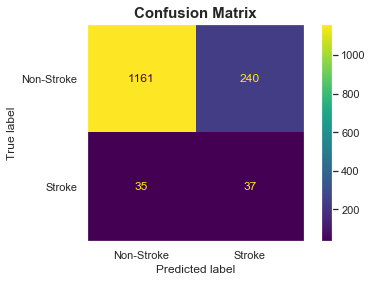

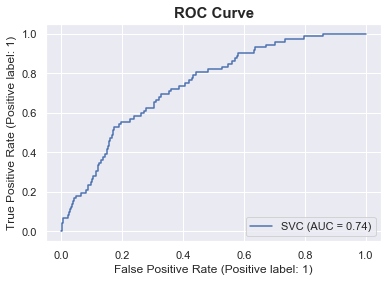

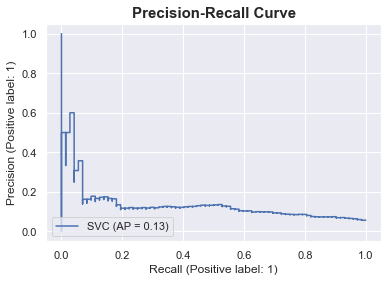

KNN Classification Report
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1401
           1       0.11      0.69      0.20        72

    accuracy                           0.72      1473
   macro avg       0.55      0.71      0.51      1473
weighted avg       0.94      0.72      0.80      1473



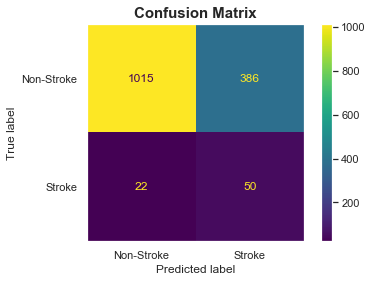

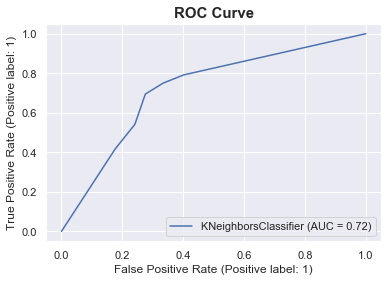

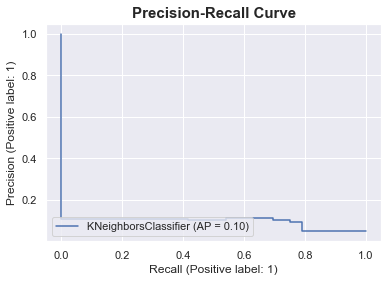

DT Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1401
           1       0.13      0.47      0.20        72

    accuracy                           0.82      1473
   macro avg       0.55      0.66      0.55      1473
weighted avg       0.93      0.82      0.86      1473



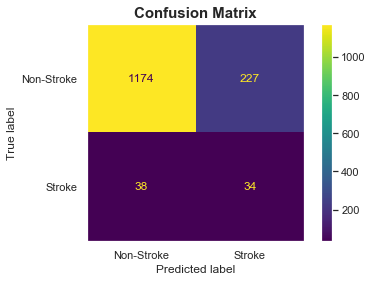

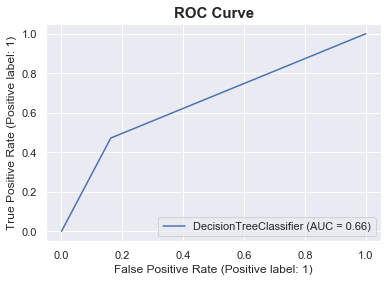

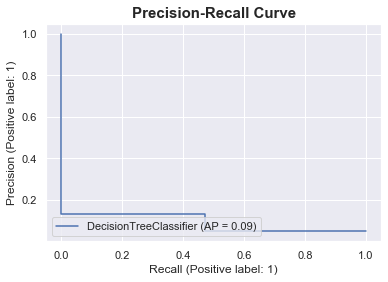

RF Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1401
           1       0.16      0.47      0.23        72

    accuracy                           0.85      1473
   macro avg       0.56      0.67      0.57      1473
weighted avg       0.93      0.85      0.88      1473



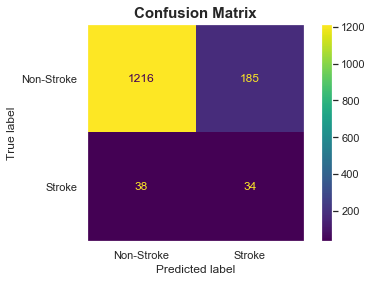

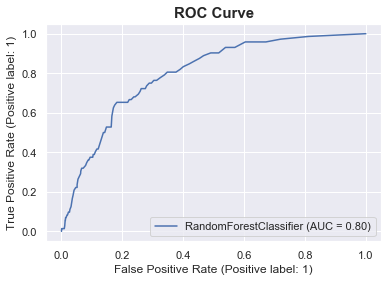

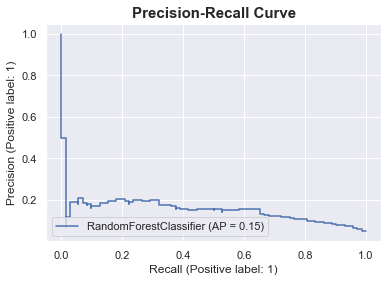

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1401
           1       0.11      0.92      0.20        72

    accuracy                           0.65      1473
   macro avg       0.55      0.78      0.49      1473
weighted avg       0.95      0.65      0.75      1473



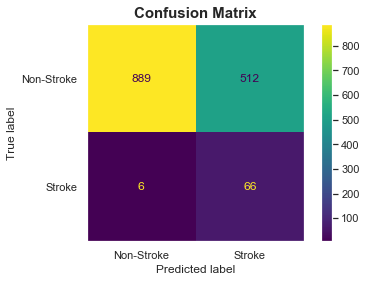

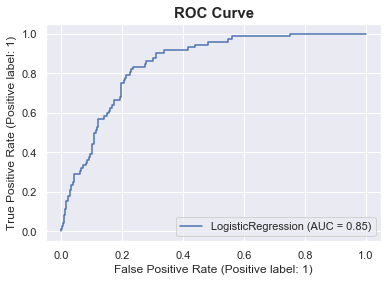

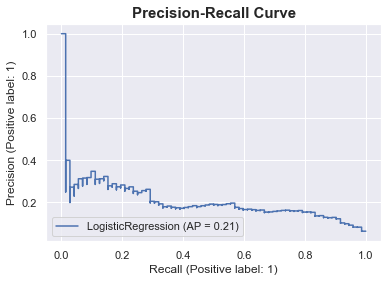

GNB Classification Report
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1401
           1       0.13      0.54      0.21        72

    accuracy                           0.80      1473
   macro avg       0.55      0.68      0.55      1473
weighted avg       0.93      0.80      0.85      1473



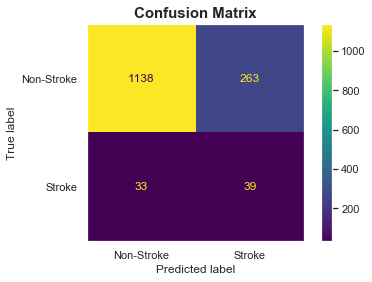

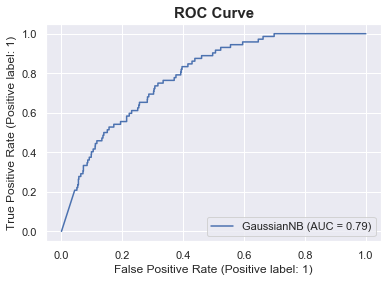

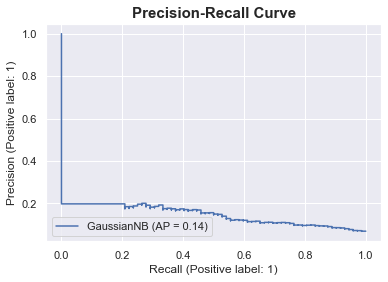

MLP Classification Report
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1401
           1       0.12      0.71      0.21        72

    accuracy                           0.73      1473
   macro avg       0.55      0.72      0.52      1473
weighted avg       0.94      0.73      0.81      1473



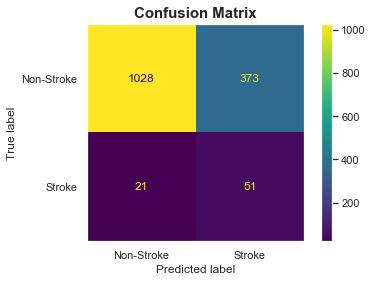

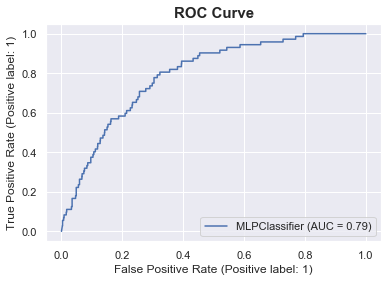

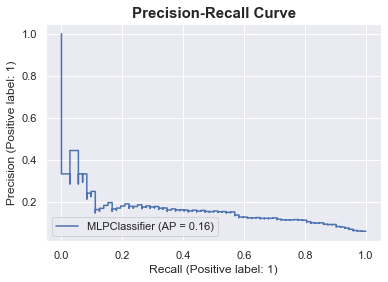

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.513889   0.133574  0.212034  0.671291  0.092403   
KNeighborsClassifier    0.694444   0.114679  0.196850  0.709463  0.094574   
DecisionTreeClassifier  0.472222   0.137097  0.212500  0.659737  0.090538   
RandomForestClassifier  0.555556   0.181818  0.273973  0.713538  0.122734   
LogisticRegression      0.916667   0.114187  0.203077  0.775607  0.108745   
GaussianNB              0.541667   0.129139  0.208556  0.676972  0.092354   
MLPClassifier           0.722222   0.135065  0.227571  0.742267  0.111125   

                             tnr  
classifiers                       
SVC                     0.828694  
KNeighborsClassifier    0.724483  
DecisionTreeClassifier  0.847252  
RandomForestClassifier  0.871520  
LogisticRegression      0.634547  
GaussianNB              0.812277  
MLPClassifier           0.762313

In [77]:
display(model_pipeline(X_removed_svm, X_test, y_removed_svm, y_test))
display(summary_pipeline(X_removed_svm, X_test, y_removed_svm, y_test))

An alternative metric to precision that we can use is specificity (or True Negative Rate), which tells us how well the model is able to detect the negative class (i.e. non-stroke patients). Attempting to increase specificity, without compromising sensitivity (i.e. recall), will decrease the false positives and maintain the low false negatives that is required for this application.

### Sensitivity and Specificity are common metrics used in the medical field.

### Logistic Regression with One-Class SVM outlier removal method gives an optimal balance between sensitivity (92%) and specificity (63%). This model ensures that sensitivity is very high (> 90%) and specificity is moderately high (> 60%). 

We can also try alternative ways of handling missing data and balancing the data (undersampling, etc.)

# Additional Data Cleaning

## Handling Missing Data - Alternative Technique

In [78]:
path = 'healthcare-dataset-stroke-data.csv'
df_new = pd.read_csv(path)
df_new.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [79]:
df_new.shape

(5110, 12)

In [80]:
df_new.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [81]:
df_new.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Let's try a different approach of handling the missing data so that we don't lose any information.

In [82]:
df_new.bmi.describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

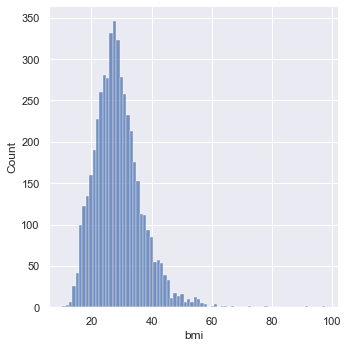

In [83]:
sns.displot(df_new, x="bmi")

BMI is approximately normally distributed with a small standard deviation. So, we will impute the missing values with the mean.

In [84]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_new.bmi = imp.fit_transform(df_new[['bmi']]).ravel()

In [85]:
df_new.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [86]:
df_new.shape

(5110, 12)

In [87]:
df_new.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [88]:
df_new.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [89]:
df_new.drop(df_new[df_new.gender == "Other"].index, inplace = True)

In [90]:
df_new.gender.value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

No information was lost in the cleaning process.

In [91]:
def data_preprocessing(data, test_size=0.3, random_state=42):
    dropped_df = data.drop('id', axis=1)
    X = dropped_df.iloc[:, :-1].values
    y = dropped_df.iloc[:, -1].values
    ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [0,4,5,6,9])], remainder = 'passthrough')
    X = np.array(ct.fit_transform(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [92]:
X_train, X_test, y_train, y_test = data_preprocessing(df_new)

SVM Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533



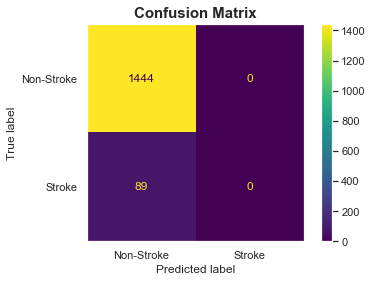

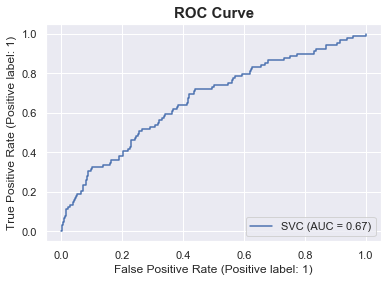

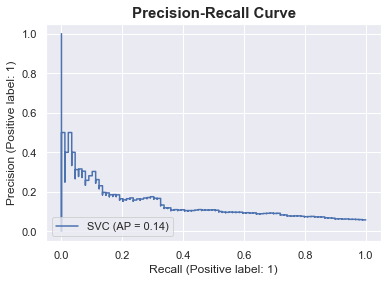

KNN Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.43      0.03      0.06        89

    accuracy                           0.94      1533
   macro avg       0.69      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



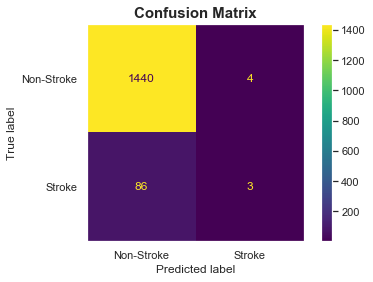

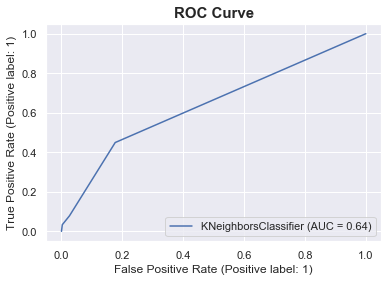

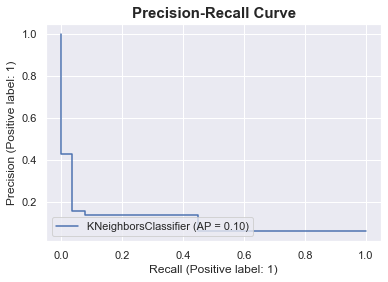

DT Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1444
           1       0.19      0.20      0.20        89

    accuracy                           0.90      1533
   macro avg       0.57      0.58      0.57      1533
weighted avg       0.91      0.90      0.91      1533



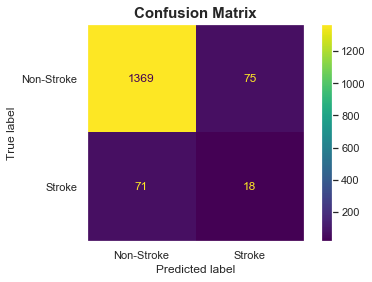

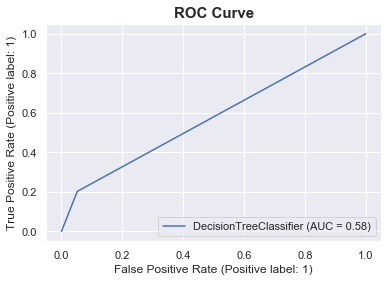

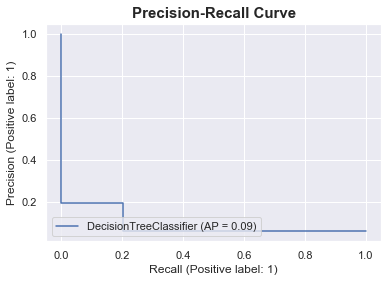

RF Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533



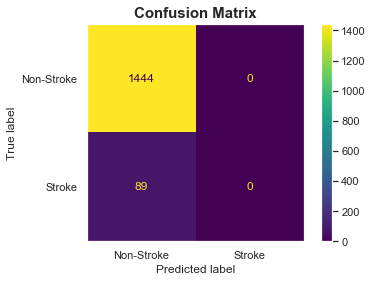

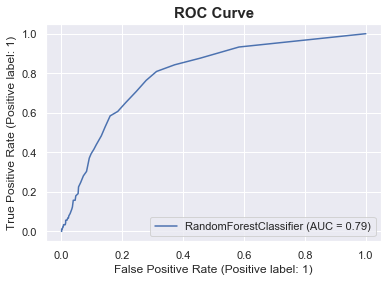

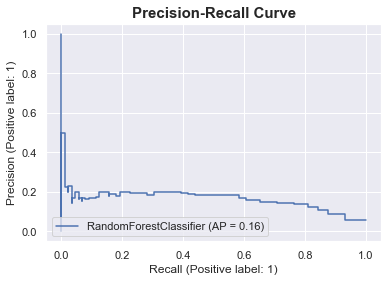

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       1.00      0.01      0.02        89

    accuracy                           0.94      1533
   macro avg       0.97      0.51      0.50      1533
weighted avg       0.95      0.94      0.92      1533



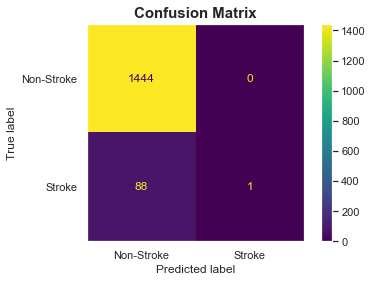

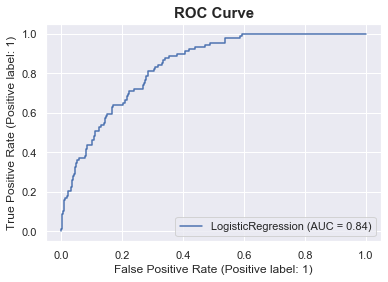

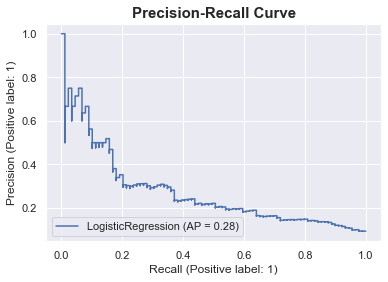

GNB Classification Report
              precision    recall  f1-score   support

           0       1.00      0.28      0.44      1444
           1       0.08      1.00      0.15        89

    accuracy                           0.32      1533
   macro avg       0.54      0.64      0.29      1533
weighted avg       0.95      0.32      0.42      1533



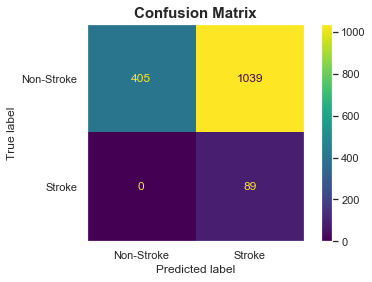

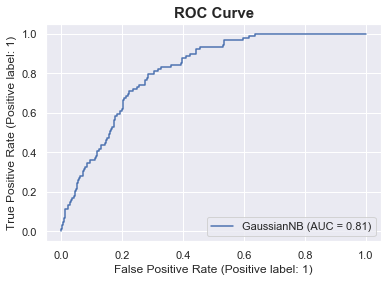

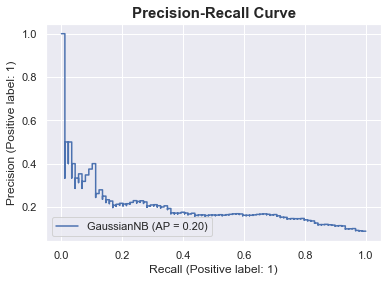

MLP Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.43      0.03      0.06        89

    accuracy                           0.94      1533
   macro avg       0.69      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



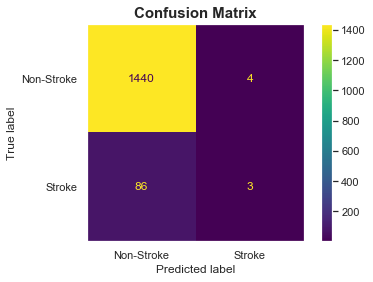

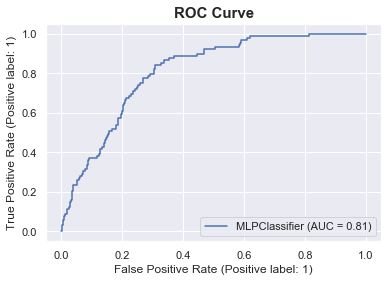

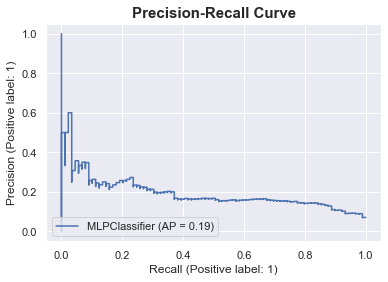

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.000000   0.000000  0.000000  0.500000  0.058056   
KNeighborsClassifier    0.033708   0.428571  0.062500  0.515469  0.070545   
DecisionTreeClassifier  0.157303   0.177215  0.166667  0.556145  0.076800   
RandomForestClassifier  0.011236   0.500000  0.021978  0.505272  0.063022   
LogisticRegression      0.011236   1.000000  0.022222  0.505618  0.068640   
GaussianNB              1.000000   0.078901  0.146261  0.640235  0.078901   
MLPClassifier           0.022472   0.285714  0.041667  0.509505  0.063172   

                             tnr  
classifiers                       
SVC                     1.000000  
KNeighborsClassifier    0.997230  
DecisionTreeClassifier  0.954986  
RandomForestClassifier  0.999307  
LogisticRegression      1.000000  
GaussianNB              0.280471  
MLPClassifier           0.996537

In [93]:
display(model_pipeline(X_train, X_test, y_train, y_test))
display(summary_pipeline(X_train, X_test, y_train, y_test))

In [94]:
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [95]:
display(Counter(y_train))
display(Counter(y_resampled))

Counter({0: 3416, 1: 160})

Counter({0: 3416, 1: 3416})

In [96]:
X_train.shape

(3576, 20)

In [97]:
X_resampled.shape

(6832, 20)

SVM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      1444
           1       0.13      0.36      0.19        89

    accuracy                           0.83      1533
   macro avg       0.54      0.61      0.55      1533
weighted avg       0.91      0.83      0.86      1533



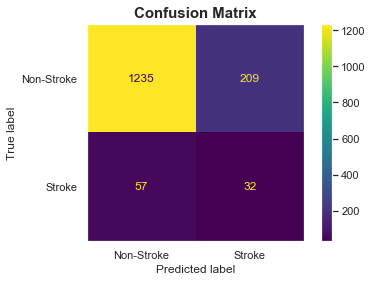

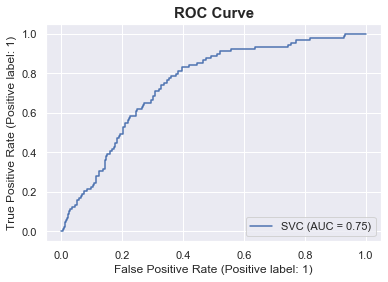

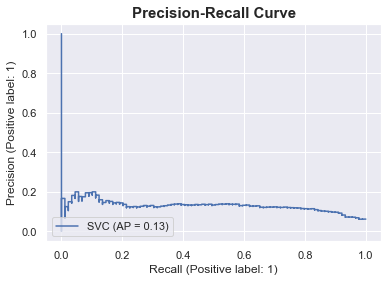

KNN Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1444
           1       0.12      0.31      0.17        89

    accuracy                           0.82      1533
   macro avg       0.54      0.58      0.54      1533
weighted avg       0.90      0.82      0.86      1533



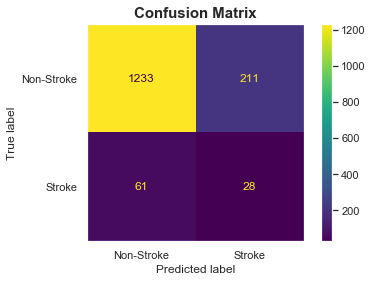

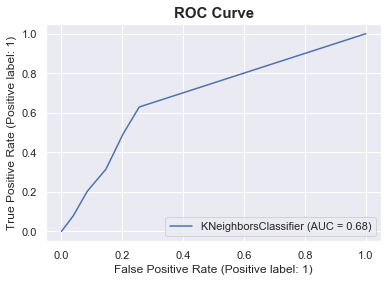

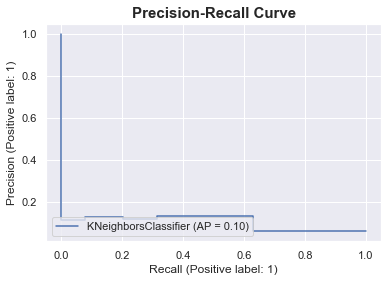

DT Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1444
           1       0.12      0.17      0.14        89

    accuracy                           0.88      1533
   macro avg       0.54      0.55      0.54      1533
weighted avg       0.90      0.88      0.89      1533



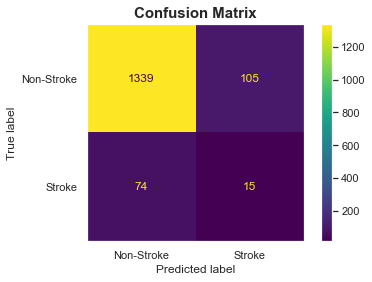

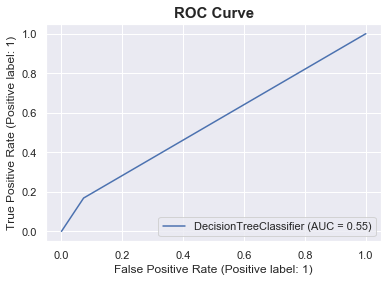

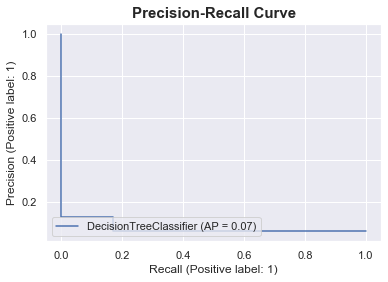

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1444
           1       0.13      0.10      0.11        89

    accuracy                           0.91      1533
   macro avg       0.54      0.53      0.53      1533
weighted avg       0.90      0.91      0.90      1533



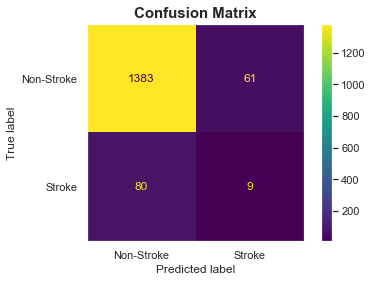

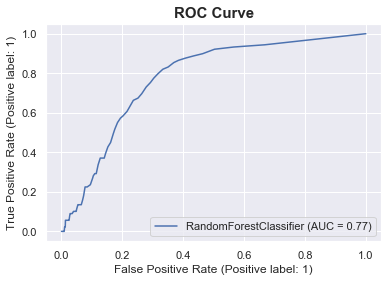

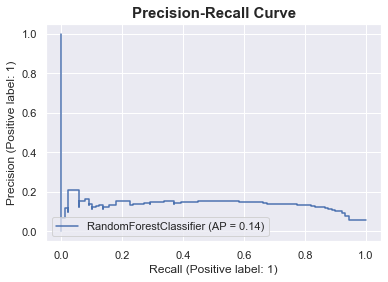

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1444
           1       0.15      0.73      0.25        89

    accuracy                           0.74      1533
   macro avg       0.56      0.74      0.55      1533
weighted avg       0.93      0.74      0.81      1533



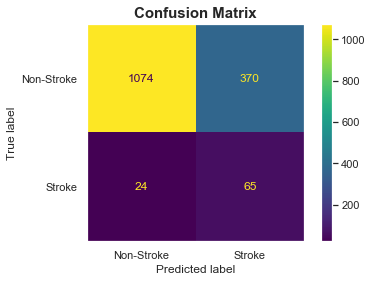

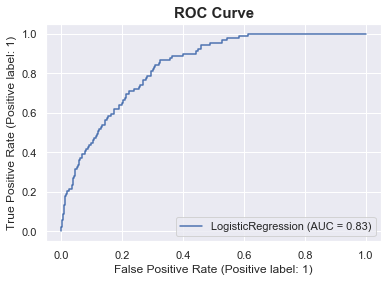

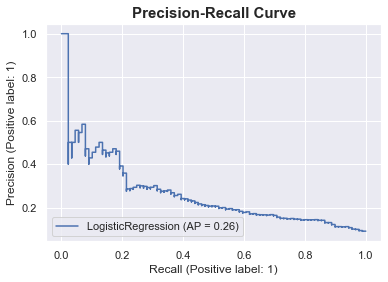

GNB Classification Report
              precision    recall  f1-score   support

           0       1.00      0.30      0.47      1444
           1       0.08      0.99      0.15        89

    accuracy                           0.34      1533
   macro avg       0.54      0.65      0.31      1533
weighted avg       0.94      0.34      0.45      1533



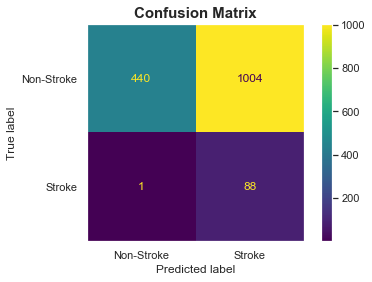

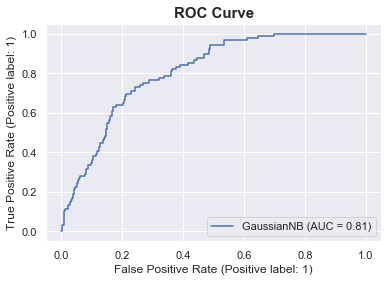

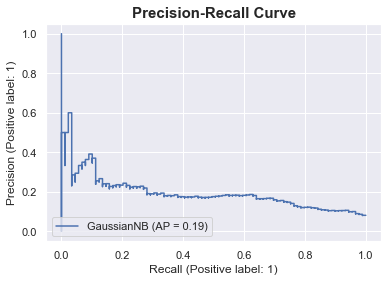

MLP Classification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1444
           1       0.14      0.20      0.16        89

    accuracy                           0.88      1533
   macro avg       0.54      0.56      0.55      1533
weighted avg       0.90      0.88      0.89      1533



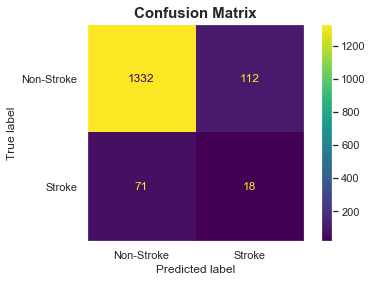

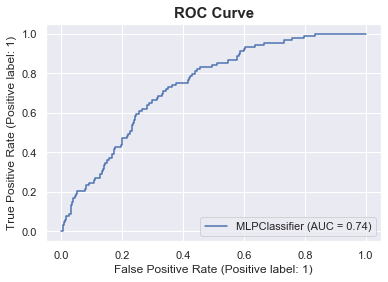

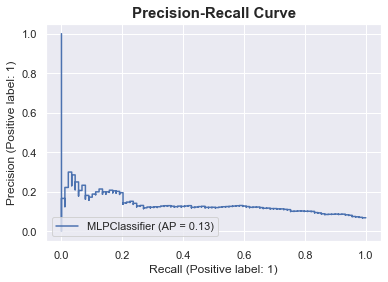

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.359551   0.132780  0.193939  0.607407  0.084923   
KNeighborsClassifier    0.314607   0.117155  0.170732  0.584242  0.076649   
DecisionTreeClassifier  0.179775   0.130081  0.150943  0.552838  0.071004   
RandomForestClassifier  0.101124   0.140625  0.117647  0.531517  0.066406   
LogisticRegression      0.730337   0.149425  0.248092  0.737052  0.124786   
GaussianNB              0.988764   0.080586  0.149026  0.646737  0.080333   
MLPClassifier           0.258427   0.166667  0.202643  0.589394  0.086124   

                             tnr  
classifiers                       
SVC                     0.855263  
KNeighborsClassifier    0.853878  
DecisionTreeClassifier  0.925900  
RandomForestClassifier  0.961911  
LogisticRegression      0.743767  
GaussianNB              0.304709  
MLPClassifier           0.920360

In [98]:
display(model_pipeline(X_resampled, X_test, y_resampled, y_test))
display(summary_pipeline(X_resampled, X_test, y_resampled, y_test))

In [99]:
X_removed_db, y_removed_db = outlier_pipeline(X_resampled,y_resampled,'DBSCAN')
X_removed_iso, y_removed_iso = outlier_pipeline(X_resampled,y_resampled,'Isolation Forest')
X_removed_lof, y_removed_lof = outlier_pipeline(X_resampled,y_resampled,'LOF')
X_removed_cov, y_removed_cov = outlier_pipeline(X_resampled,y_resampled,'Robust Covariance')
X_removed_svm, y_removed_svm = outlier_pipeline(X_resampled,y_resampled,'One-Class SVM')

{'algorithm': 'auto', 'eps': 0.3, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 5, 'n_jobs': None, 'p': None}

Counts of each label after anomaly detection algorithm is applied: Counter({-1: 4812, 49: 99, 10: 97, 7: 86, 3: 86, 5: 86, 31: 67, 12: 59, 30: 59, 29: 53, 13: 49, 33: 42, 16: 32, 0: 30, 42: 30, 70: 26, 19: 25, 56: 25, 64: 25, 22: 23, 39: 23, 18: 22, 82: 22, 87: 22, 45: 20, 44: 19, 96: 16, 8: 15, 14: 15, 61: 15, 74: 15, 117: 15, 6: 14, 23: 14, 25: 14, 34: 13, 58: 13, 67: 13, 95: 12, 65: 12, 113: 12, 24: 11, 26: 11, 51: 11, 112: 11, 111: 11, 69: 11, 75: 11, 78: 11, 83: 11, 88: 11, 106: 11, 27: 10, 50: 10, 52: 10, 77: 10, 85: 10, 91: 10, 98: 10, 99: 10, 21: 9, 43: 9, 115: 9, 1: 8, 124: 8, 66: 8, 100: 8, 103: 8, 119: 8, 4: 7, 46: 7, 37: 7, 38: 7, 125: 7, 48: 7, 55: 7, 60: 7, 71: 7, 76: 7, 118: 7, 131: 7, 130: 7, 62: 6, 2: 6, 11: 6, 20: 6, 73: 6, 32: 6, 35: 6, 81: 6, 53: 6, 126: 6, 57: 6, 72: 6, 84: 6, 92: 6, 101: 6, 121: 6, 102: 6, 114: 6, 120: 6, 1

SVM Classification Report
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      1444
           1       0.09      0.98      0.16        89

    accuracy                           0.39      1533
   macro avg       0.54      0.67      0.34      1533
weighted avg       0.94      0.39      0.51      1533



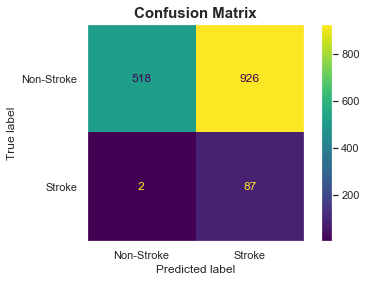

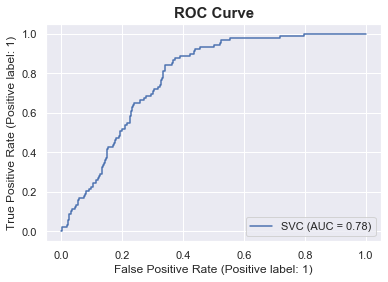

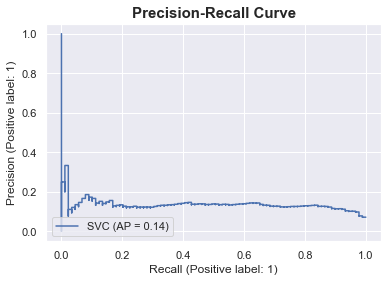

KNN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.41      0.58      1444
           1       0.09      0.96      0.16        89

    accuracy                           0.44      1533
   macro avg       0.54      0.68      0.37      1533
weighted avg       0.94      0.44      0.55      1533



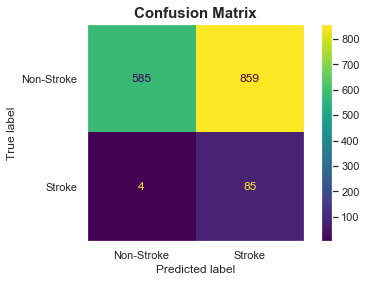

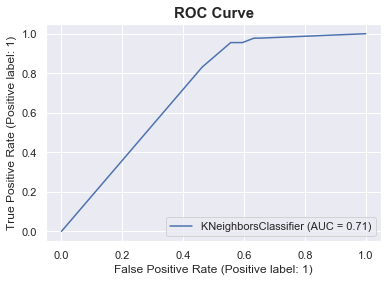

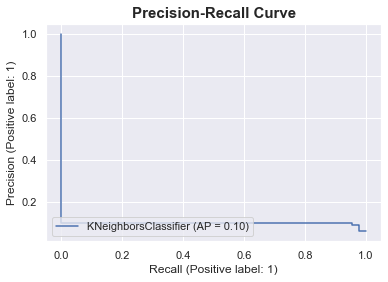

DT Classification Report
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1444
           1       0.11      0.74      0.20        89

    accuracy                           0.65      1533
   macro avg       0.55      0.69      0.49      1533
weighted avg       0.93      0.65      0.74      1533



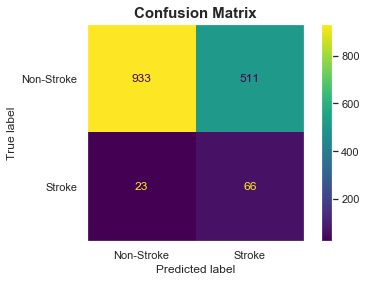

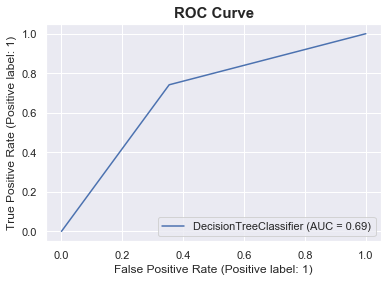

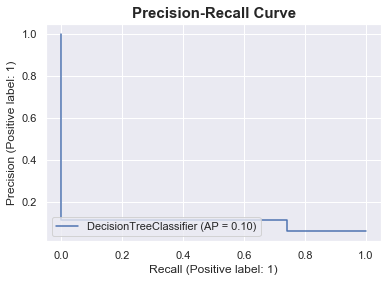

RF Classification Report
              precision    recall  f1-score   support

           0       0.99      0.55      0.70      1444
           1       0.11      0.91      0.20        89

    accuracy                           0.57      1533
   macro avg       0.55      0.73      0.45      1533
weighted avg       0.94      0.57      0.68      1533



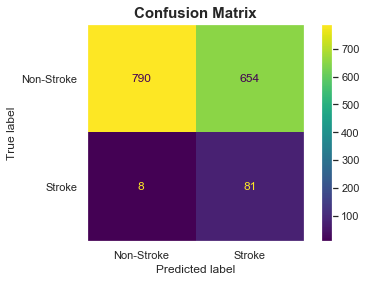

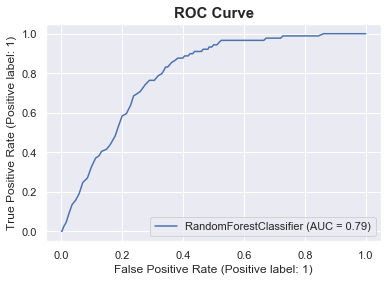

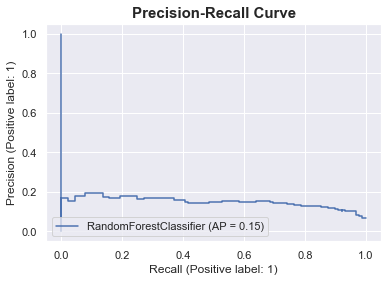

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.45      0.62      1444
           1       0.10      0.96      0.18        89

    accuracy                           0.48      1533
   macro avg       0.55      0.70      0.40      1533
weighted avg       0.94      0.48      0.59      1533



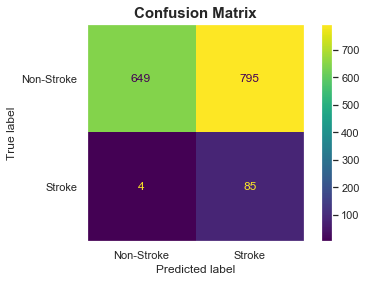

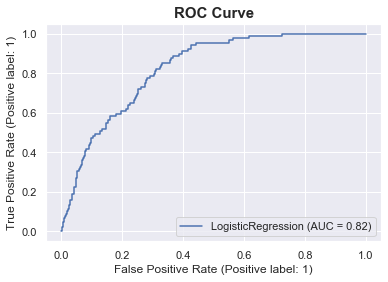

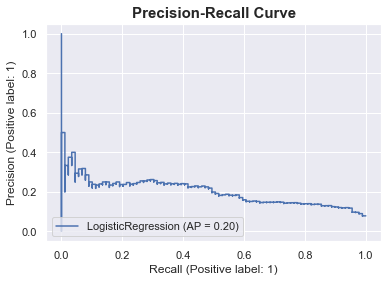

GNB Classification Report
              precision    recall  f1-score   support

           0       0.99      0.43      0.60      1444
           1       0.09      0.92      0.16        89

    accuracy                           0.46      1533
   macro avg       0.54      0.67      0.38      1533
weighted avg       0.94      0.46      0.57      1533



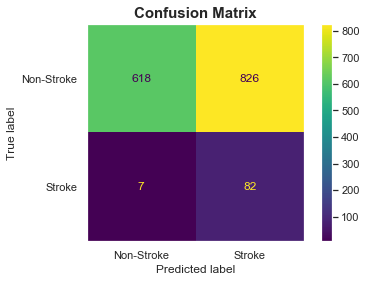

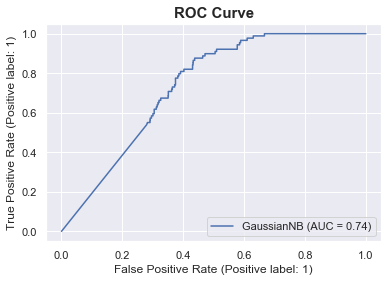

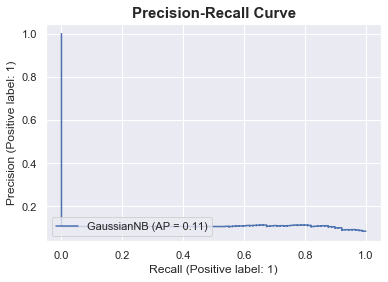

MLP Classification Report
              precision    recall  f1-score   support

           0       0.99      0.41      0.58      1444
           1       0.09      0.96      0.17        89

    accuracy                           0.45      1533
   macro avg       0.54      0.68      0.38      1533
weighted avg       0.94      0.45      0.56      1533



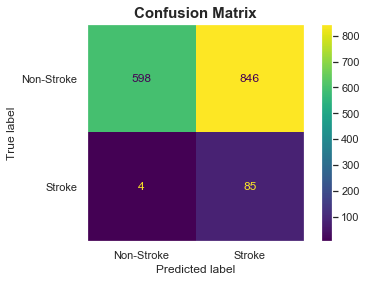

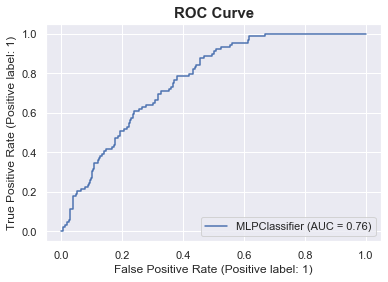

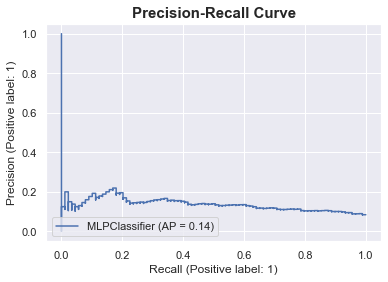

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.977528   0.085884  0.157895  0.668127  0.085258   
KNeighborsClassifier    0.955056   0.090042  0.164569  0.680090  0.088605   
DecisionTreeClassifier  0.752809   0.112416  0.195620  0.693233  0.098979   
RandomForestClassifier  0.887640   0.108368  0.193154  0.718751  0.102715   
LogisticRegression      0.955056   0.096591  0.175439  0.702251  0.094859   
GaussianNB              0.921348   0.090308  0.164493  0.674663  0.087772   
MLPClassifier           0.966292   0.090909  0.166184  0.685362  0.089802   

                             tnr  
classifiers                       
SVC                     0.358726  
KNeighborsClassifier    0.405125  
DecisionTreeClassifier  0.633657  
RandomForestClassifier  0.549861  
LogisticRegression      0.449446  
GaussianNB              0.427978  
MLPClassifier           0.404432

In [100]:
display(model_pipeline(X_removed_db, X_test, y_removed_db, y_test))
display(summary_pipeline(X_removed_db, X_test, y_removed_db, y_test))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      1444
           1       0.13      0.36      0.20        89

    accuracy                           0.83      1533
   macro avg       0.54      0.61      0.55      1533
weighted avg       0.91      0.83      0.86      1533



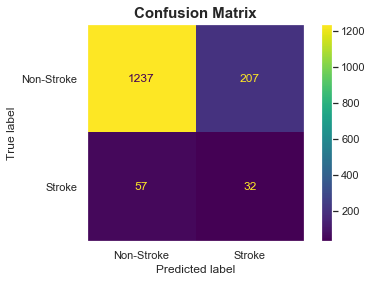

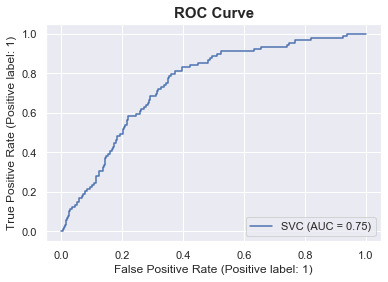

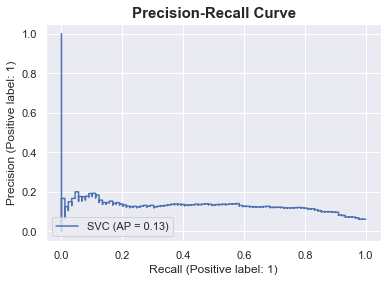

KNN Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1444
           1       0.12      0.33      0.18        89

    accuracy                           0.82      1533
   macro avg       0.54      0.59      0.54      1533
weighted avg       0.91      0.82      0.86      1533



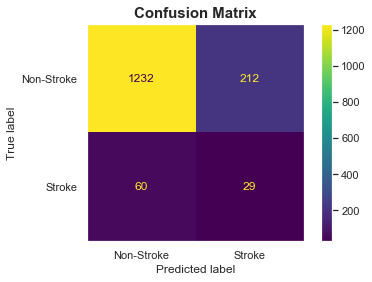

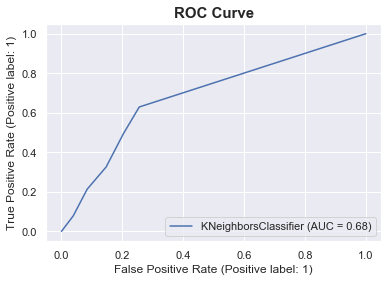

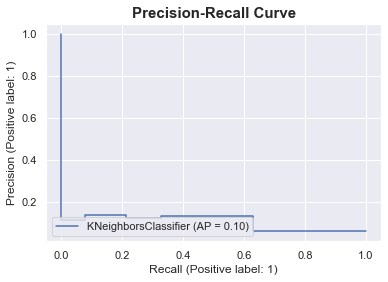

DT Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1444
           1       0.17      0.24      0.20        89

    accuracy                           0.89      1533
   macro avg       0.56      0.58      0.57      1533
weighted avg       0.91      0.89      0.90      1533



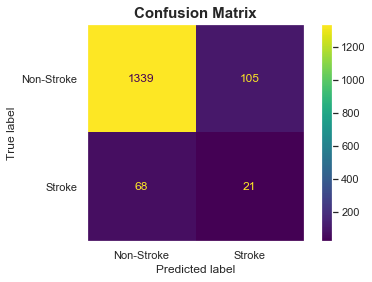

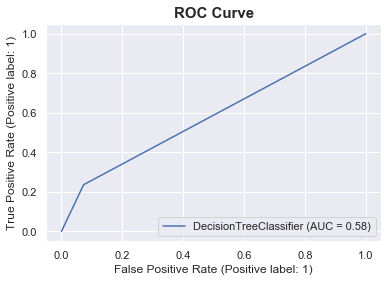

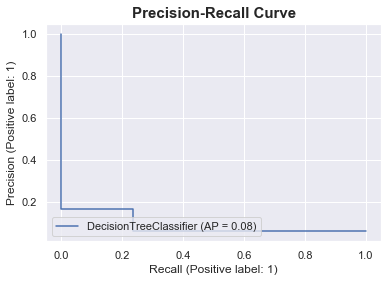

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1444
           1       0.14      0.10      0.12        89

    accuracy                           0.91      1533
   macro avg       0.54      0.53      0.54      1533
weighted avg       0.90      0.91      0.91      1533



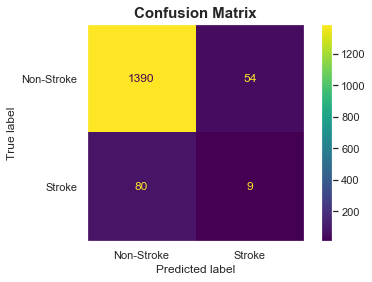

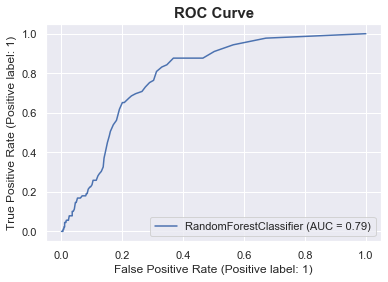

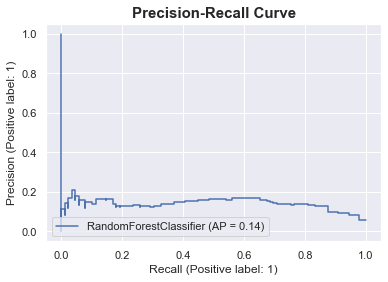

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1444
           1       0.15      0.72      0.24        89

    accuracy                           0.74      1533
   macro avg       0.56      0.73      0.54      1533
weighted avg       0.93      0.74      0.81      1533



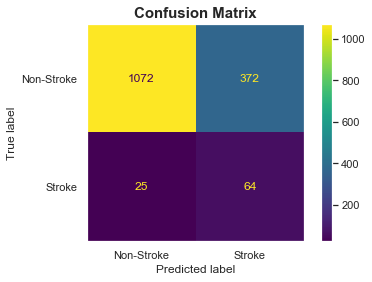

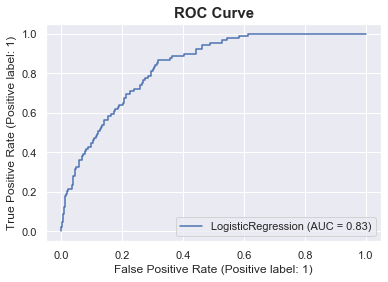

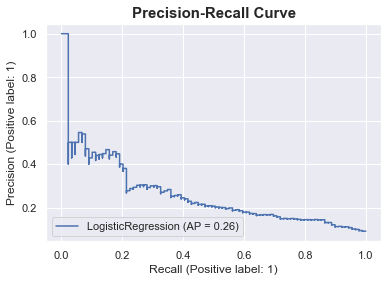

GNB Classification Report
              precision    recall  f1-score   support

           0       1.00      0.31      0.47      1444
           1       0.08      1.00      0.15        89

    accuracy                           0.35      1533
   macro avg       0.54      0.65      0.31      1533
weighted avg       0.95      0.35      0.45      1533



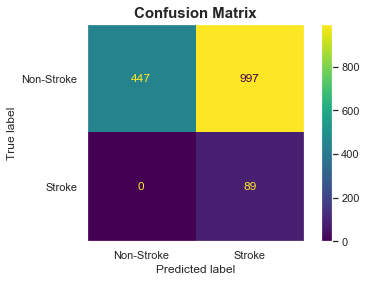

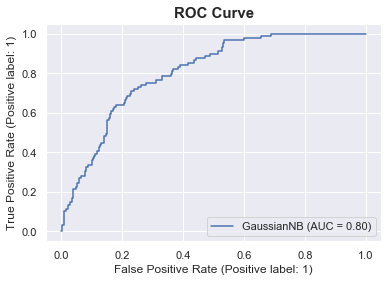

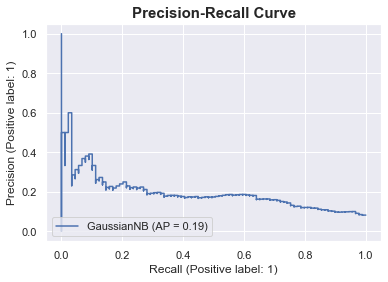

MLP Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1444
           1       0.15      0.21      0.18        89

    accuracy                           0.89      1533
   macro avg       0.55      0.57      0.56      1533
weighted avg       0.90      0.89      0.89      1533



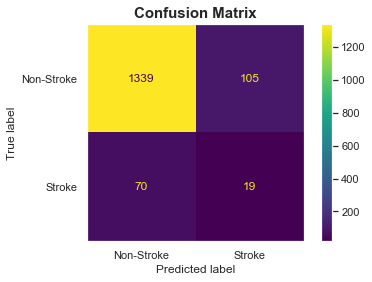

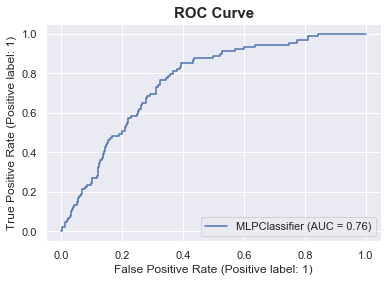

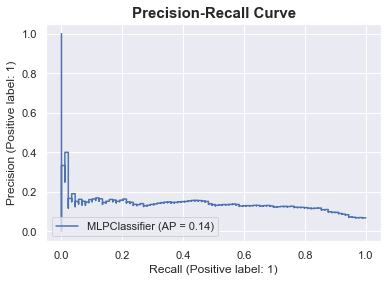

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.359551   0.133891  0.195122  0.608099  0.085323   
KNeighborsClassifier    0.325843   0.120332  0.175758  0.589514  0.078348   
DecisionTreeClassifier  0.269663   0.179104  0.215247  0.596743  0.090698   
RandomForestClassifier  0.101124   0.134328  0.115385  0.530479  0.065769   
LogisticRegression      0.719101   0.146789  0.243810  0.730742  0.121864   
GaussianNB              1.000000   0.081952  0.151489  0.654778  0.081952   
MLPClassifier           0.224719   0.142857  0.174672  0.570808  0.077113   

                             tnr  
classifiers                       
SVC                     0.856648  
KNeighborsClassifier    0.853186  
DecisionTreeClassifier  0.923823  
RandomForestClassifier  0.959834  
LogisticRegression      0.742382  
GaussianNB              0.309557  
MLPClassifier           0.916898

In [101]:
display(model_pipeline(X_removed_iso, X_test, y_removed_iso, y_test))
display(summary_pipeline(X_removed_iso, X_test, y_removed_iso, y_test))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1444
           1       0.14      0.38      0.20        89

    accuracy                           0.83      1533
   macro avg       0.55      0.62      0.55      1533
weighted avg       0.91      0.83      0.86      1533



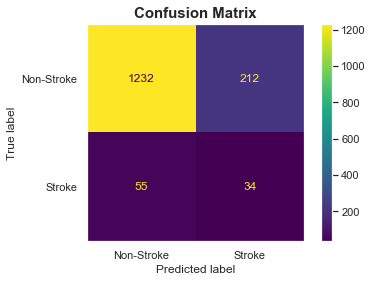

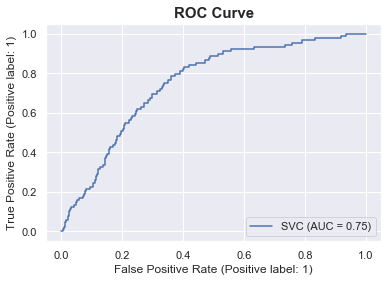

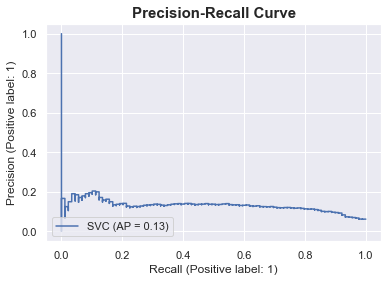

KNN Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1444
           1       0.12      0.33      0.17        89

    accuracy                           0.82      1533
   macro avg       0.54      0.59      0.54      1533
weighted avg       0.90      0.82      0.86      1533



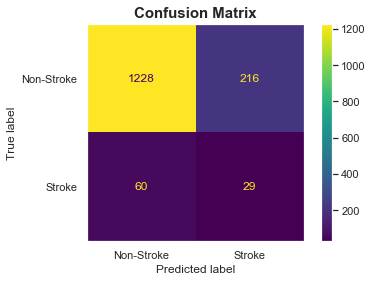

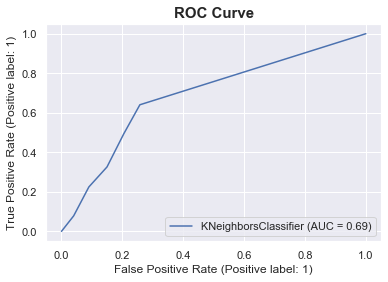

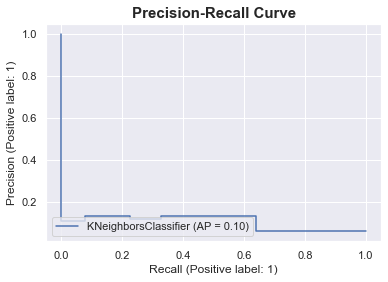

DT Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1444
           1       0.14      0.19      0.16        89

    accuracy                           0.88      1533
   macro avg       0.54      0.56      0.55      1533
weighted avg       0.90      0.88      0.89      1533



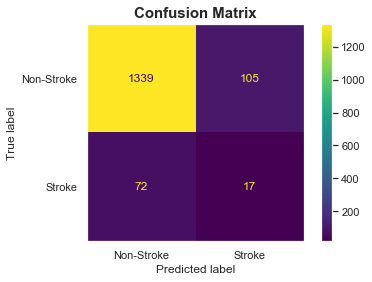

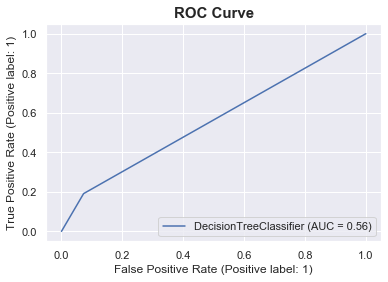

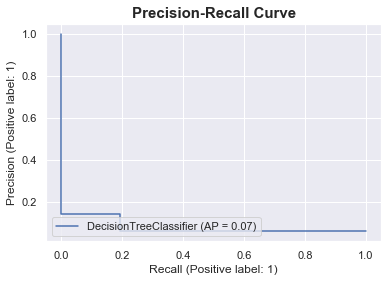

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1444
           1       0.14      0.10      0.12        89

    accuracy                           0.91      1533
   macro avg       0.54      0.53      0.53      1533
weighted avg       0.90      0.91      0.90      1533



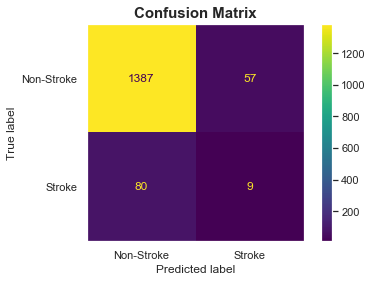

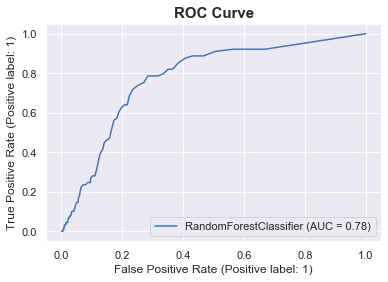

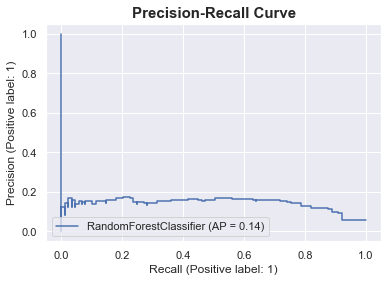

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1444
           1       0.15      0.73      0.25        89

    accuracy                           0.74      1533
   macro avg       0.56      0.74      0.55      1533
weighted avg       0.93      0.74      0.81      1533



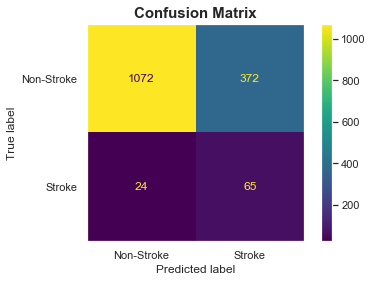

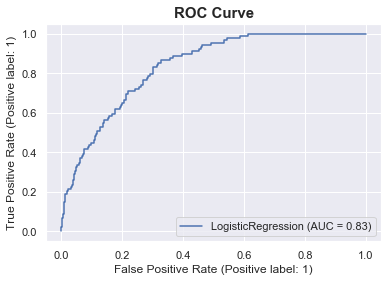

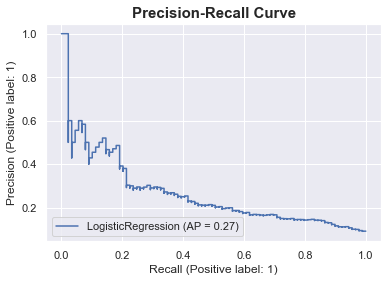

GNB Classification Report
              precision    recall  f1-score   support

           0       1.00      0.30      0.47      1444
           1       0.08      0.99      0.15        89

    accuracy                           0.34      1533
   macro avg       0.54      0.65      0.31      1533
weighted avg       0.94      0.34      0.45      1533



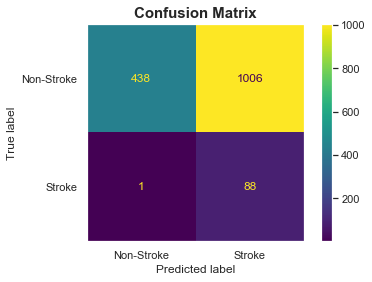

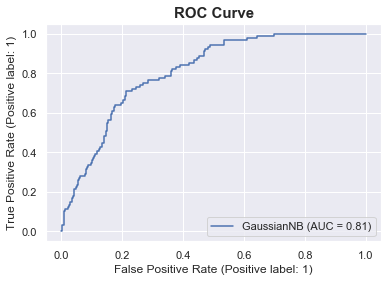

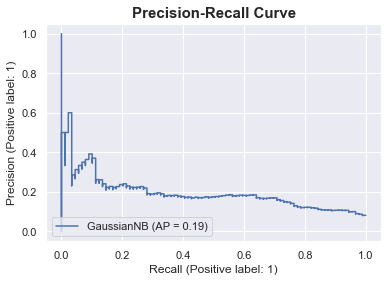

MLP Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1444
           1       0.16      0.27      0.20        89

    accuracy                           0.87      1533
   macro avg       0.56      0.59      0.57      1533
weighted avg       0.91      0.87      0.89      1533



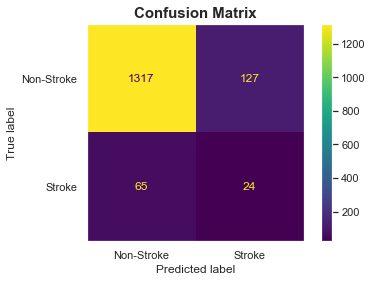

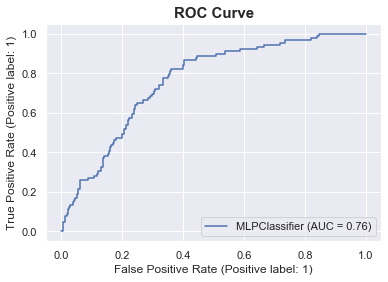

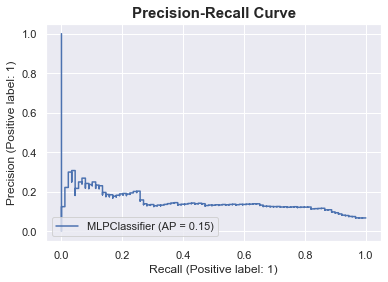

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.382022   0.138211  0.202985  0.617604  0.088677   
KNeighborsClassifier    0.325843   0.118367  0.173653  0.588129  0.077708   
DecisionTreeClassifier  0.202247   0.144000  0.168224  0.564074  0.075438   
RandomForestClassifier  0.101124   0.138462  0.116883  0.531171  0.066187   
LogisticRegression      0.730337   0.148741  0.247148  0.736360  0.124287   
GaussianNB              0.988764   0.080439  0.148774  0.646044  0.080187   
MLPClassifier           0.213483   0.149606  0.175926  0.569345  0.077601   

                             tnr  
classifiers                       
SVC                     0.853186  
KNeighborsClassifier    0.850416  
DecisionTreeClassifier  0.925900  
RandomForestClassifier  0.961219  
LogisticRegression      0.742382  
GaussianNB              0.303324  
MLPClassifier           0.925208

In [102]:
display(model_pipeline(X_removed_lof, X_test, y_removed_lof, y_test))
display(summary_pipeline(X_removed_lof, X_test, y_removed_lof, y_test))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1444
           1       0.13      0.38      0.19        89

    accuracy                           0.82      1533
   macro avg       0.54      0.61      0.55      1533
weighted avg       0.91      0.82      0.86      1533



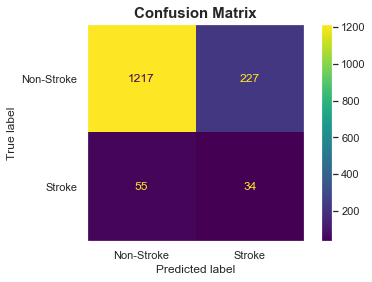

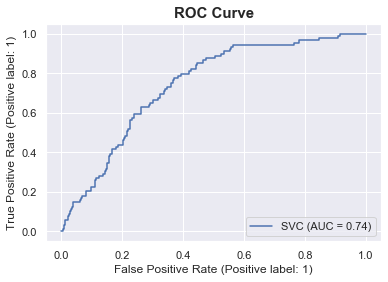

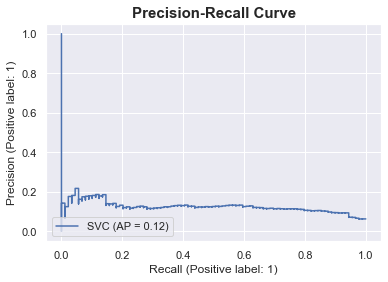

KNN Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1444
           1       0.10      0.35      0.15        89

    accuracy                           0.78      1533
   macro avg       0.53      0.58      0.51      1533
weighted avg       0.90      0.78      0.83      1533



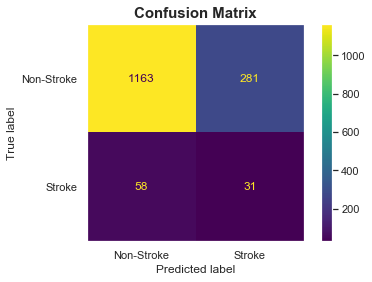

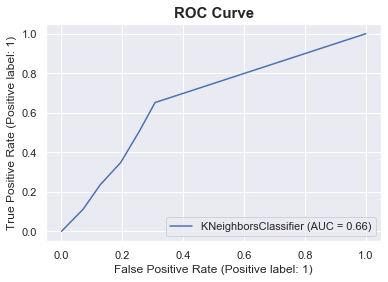

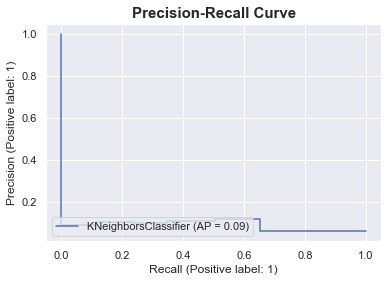

DT Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1444
           1       0.17      0.30      0.21        89

    accuracy                           0.87      1533
   macro avg       0.56      0.60      0.57      1533
weighted avg       0.91      0.87      0.89      1533



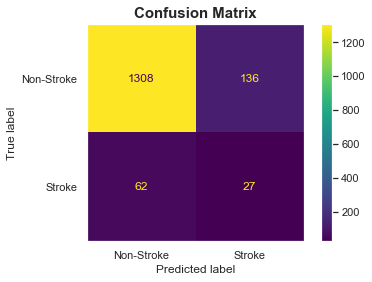

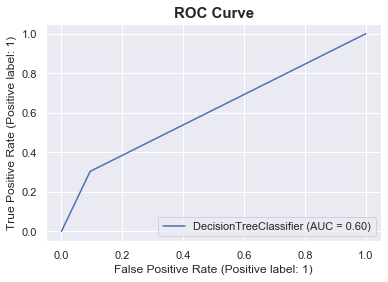

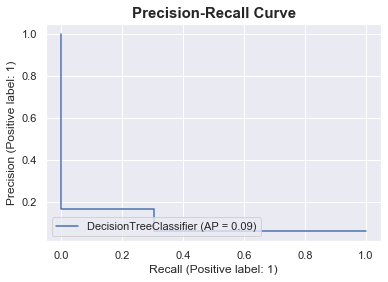

RF Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1444
           1       0.12      0.10      0.11        89

    accuracy                           0.90      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.90      0.90      0.90      1533



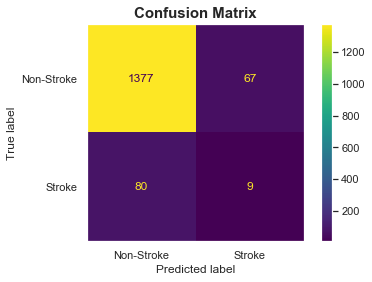

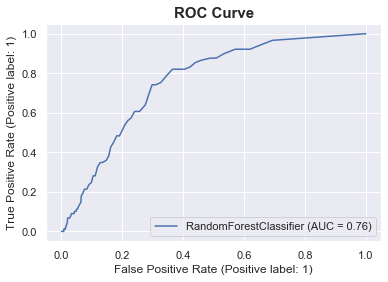

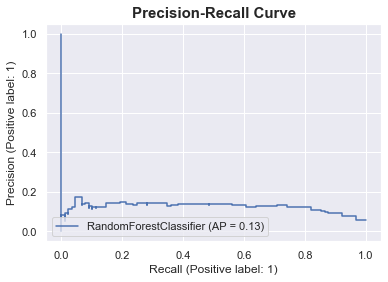

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1444
           1       0.15      0.74      0.24        89

    accuracy                           0.73      1533
   macro avg       0.56      0.74      0.54      1533
weighted avg       0.93      0.73      0.80      1533



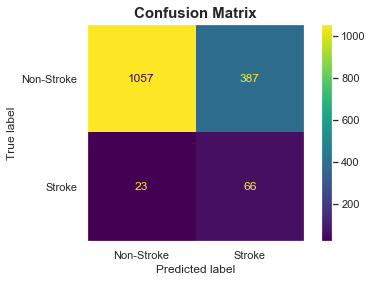

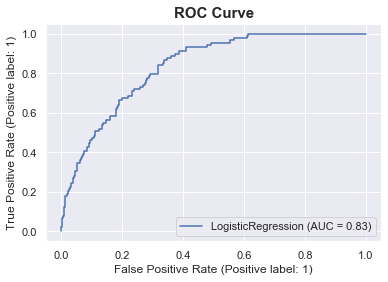

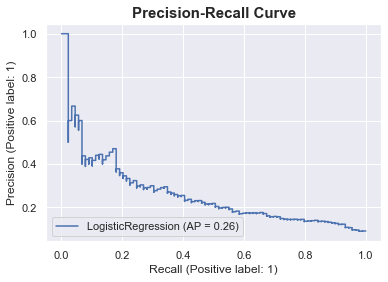

GNB Classification Report
              precision    recall  f1-score   support

           0       1.00      0.30      0.46      1444
           1       0.08      1.00      0.15        89

    accuracy                           0.34      1533
   macro avg       0.54      0.65      0.30      1533
weighted avg       0.95      0.34      0.44      1533



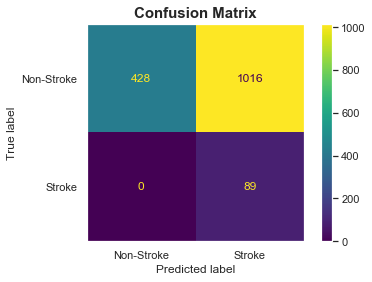

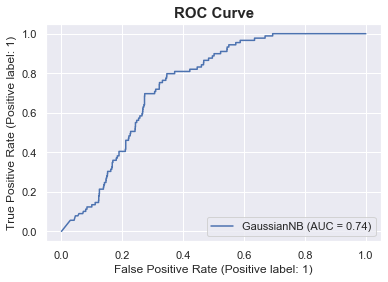

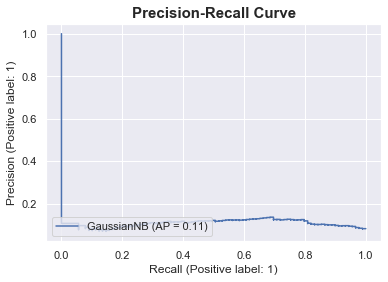

MLP Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1444
           1       0.10      0.24      0.14        89

    accuracy                           0.83      1533
   macro avg       0.52      0.55      0.52      1533
weighted avg       0.90      0.83      0.86      1533



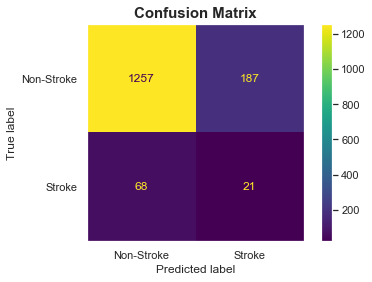

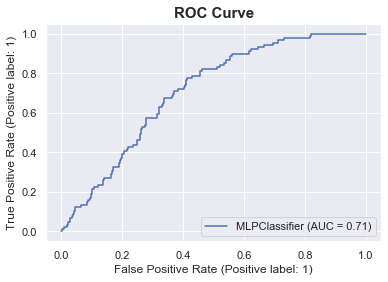

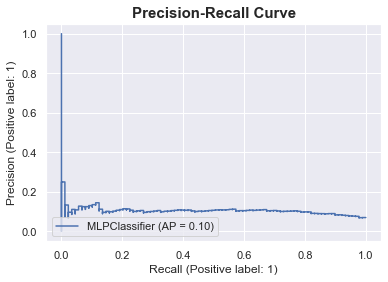

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.382022   0.130268  0.194286  0.612410  0.085643   
KNeighborsClassifier    0.348315   0.099359  0.154613  0.576858  0.072442   
DecisionTreeClassifier  0.303371   0.165644  0.214286  0.604594  0.090695   
RandomForestClassifier  0.101124   0.123288  0.111111  0.528401  0.064653   
LogisticRegression      0.741573   0.145695  0.243542  0.736784  0.123047   
GaussianNB              1.000000   0.080543  0.149079  0.648199  0.080543   
MLPClassifier           0.258427   0.119171  0.163121  0.570349  0.073850   

                             tnr  
classifiers                       
SVC                     0.842798  
KNeighborsClassifier    0.805402  
DecisionTreeClassifier  0.905817  
RandomForestClassifier  0.955679  
LogisticRegression      0.731994  
GaussianNB              0.296399  
MLPClassifier           0.882271

In [103]:
display(model_pipeline(X_removed_cov, X_test, y_removed_cov, y_test))
display(summary_pipeline(X_removed_cov, X_test, y_removed_cov, y_test))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      1444
           1       0.14      0.47      0.22        89

    accuracy                           0.80      1533
   macro avg       0.55      0.65      0.55      1533
weighted avg       0.91      0.80      0.85      1533



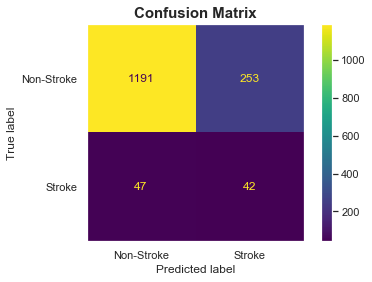

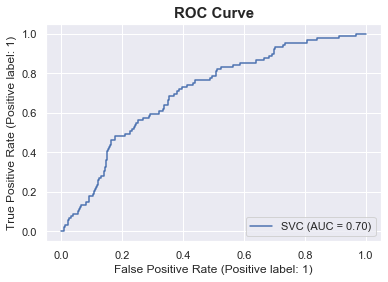

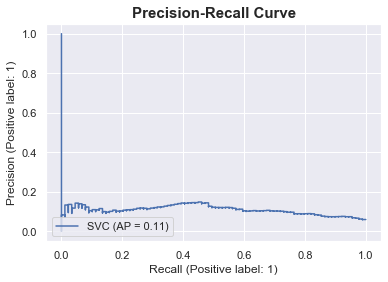

KNN Classification Report
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      1444
           1       0.11      0.64      0.19        89

    accuracy                           0.69      1533
   macro avg       0.54      0.67      0.50      1533
weighted avg       0.92      0.69      0.77      1533



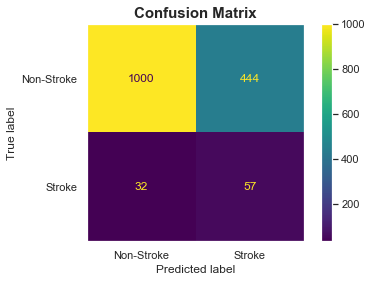

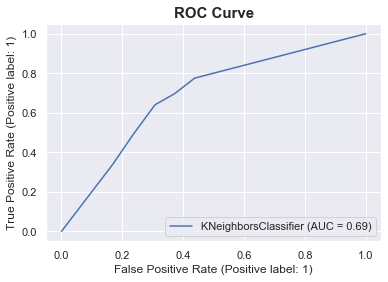

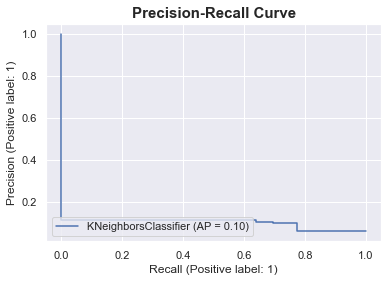

DT Classification Report
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1444
           1       0.12      0.40      0.18        89

    accuracy                           0.79      1533
   macro avg       0.54      0.61      0.53      1533
weighted avg       0.91      0.79      0.84      1533



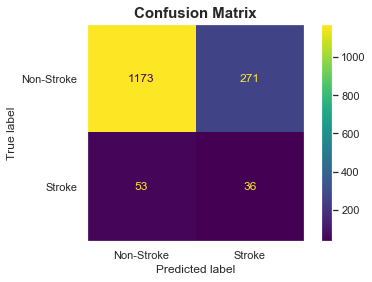

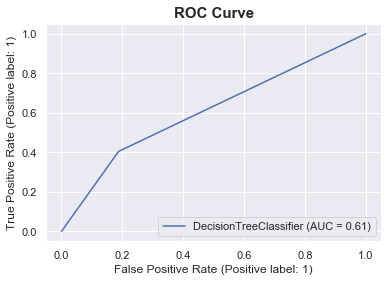

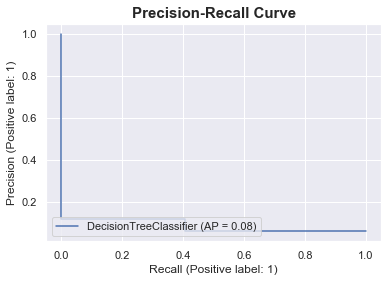

RF Classification Report
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1444
           1       0.15      0.39      0.21        89

    accuracy                           0.83      1533
   macro avg       0.55      0.63      0.56      1533
weighted avg       0.91      0.83      0.87      1533



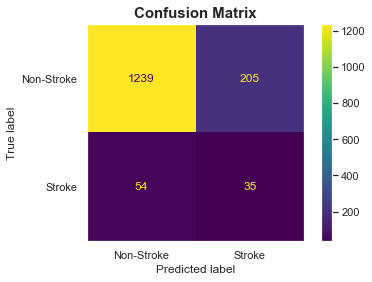

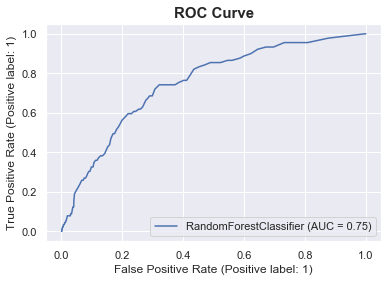

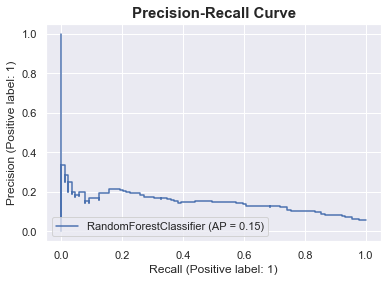

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1444
           1       0.13      0.85      0.22        89

    accuracy                           0.65      1533
   macro avg       0.56      0.74      0.50      1533
weighted avg       0.94      0.65      0.74      1533



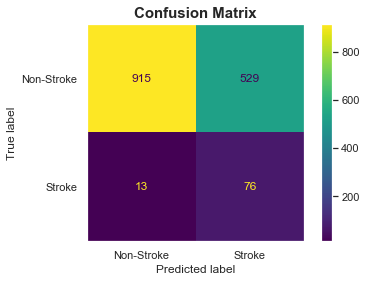

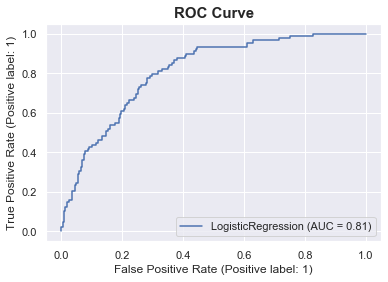

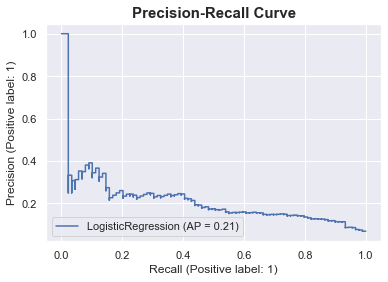

GNB Classification Report
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1444
           1       0.13      0.51      0.20        89

    accuracy                           0.77      1533
   macro avg       0.55      0.65      0.54      1533
weighted avg       0.91      0.77      0.83      1533



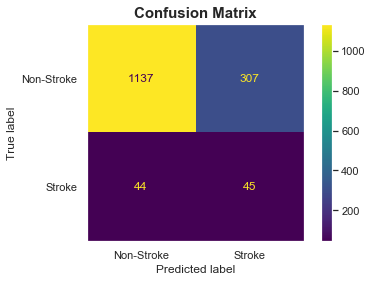

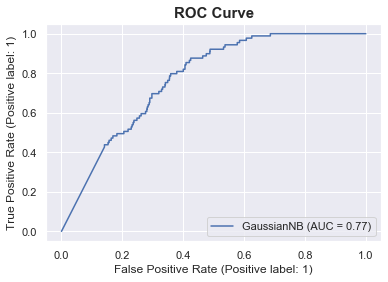

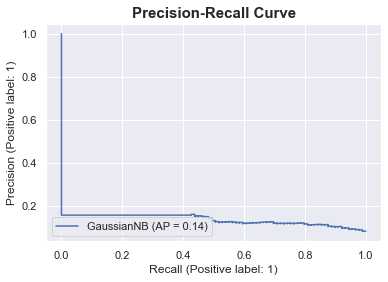

MLP Classification Report
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      1444
           1       0.12      0.63      0.20        89

    accuracy                           0.72      1533
   macro avg       0.55      0.68      0.52      1533
weighted avg       0.92      0.72      0.79      1533



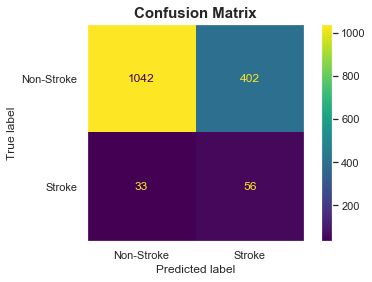

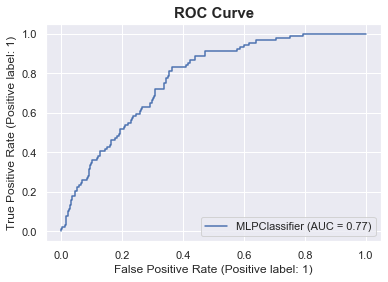

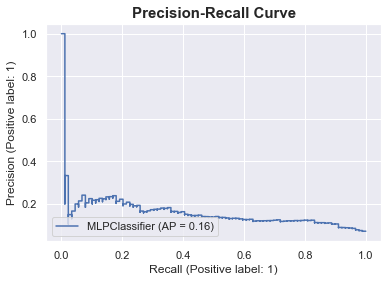

None

recall  precision  f1-score       auc        ap  \
classifiers                                                                 
SVC                     0.471910   0.142373  0.218750  0.648351  0.097846   
KNeighborsClassifier    0.640449   0.113772  0.193220  0.666485  0.093740   
DecisionTreeClassifier  0.426966   0.119497  0.186732  0.616530  0.084289   
RandomForestClassifier  0.449438   0.166667  0.243161  0.655467  0.106870   
LogisticRegression      0.853933   0.125620  0.219020  0.743795  0.115751   
GaussianNB              0.505618   0.127841  0.204082  0.646507  0.093341   
MLPClassifier           0.640449   0.122845  0.206148  0.679297  0.099550   

                             tnr  
classifiers                       
SVC                     0.824792  
KNeighborsClassifier    0.692521  
DecisionTreeClassifier  0.806094  
RandomForestClassifier  0.861496  
LogisticRegression      0.633657  
GaussianNB              0.787396  
MLPClassifier           0.718144

In [104]:
display(model_pipeline(X_removed_svm, X_test, y_removed_svm, y_test))
display(summary_pipeline(X_removed_svm, X_test, y_removed_svm, y_test))

Replacing the missing data with the mean instead of removing it reduces the predictive capability of the models. So, we will go back to the original method of handling the missing data.

# -------------------------------------------------------------------------------------------

# Further Work:

# Feature Selection

# Ensemble Outlier Removal

# Hyperparameter Optimization

# Ensemble Learning

# Neural Networks

# Cross-Validation